## Soiling Intervals Detection

This data set of current-voltage (I-V) curves and associated meteorological data for photovoltaic (PV) modules representing a flat-plate PV for one-year period. These publicly available data are intended to facilitate the validation of existing models for predicting the performance of PV modules and for the development of new and improved models. The data include a wide range of irradiance and temperature conditions representing each season.

The data include the following periods:

• Eugene – December 20, 2012, through January 20, 2014

• Cocoa – January 21, 2011, through March 4, 2012

• Golden – August 14, 2012, through September 24, 2013

In this notebook we are going to study the aforementioned dataset in order to identify periods of underperfoming due to soiling.

#### Loading Libraries

In [1]:
%matplotlib inline
import os,sys
import warnings
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
# from genmod.solarpaper import parse_csv
# from genmod.popu import *
# from genmod.procedure_fitness import *
# from genmod.listes import *
# from genmod.plot_eval import *
from genlib import *


#### Loading dataset

We denote the variables we extract from our datasets.

**poa**: The amount of solar irradiance in watts per square meter received on the PV module surface at the time indicated.

**mod_temp**: PV module back-surface temperature in degrees Celsius at the time indicated, measured behind center of cell near center of PV module.

**power**: Maximum power of PV module in watts at the time indicated.

**humidity**: Relative humidity at the site in percent, nearest 5-second average to the time indicated.

**precipitation**: Accumulated daily total precipitation in millimeters at the time indicated.

**soiling_derate**: Normalized metric comparing daily performance of a PV module to an identical PV module that is cleaned during daily maintenance.

In [2]:
import pandas as pd
filename ='eugene.csv'

df=pd.read_csv(filename)
df['timestamp']=pd.to_datetime(df['timestamp'])
df=df.set_index('timestamp')
if filename=='golden.csv':
  df=df.loc[:'2013-06-24']


print('We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event')
# print(f'The Features of are set are {df.columns}')
print(f'Shape of our Timeseries: {df.shape}')
df


We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (355, 7)


,poa,mod_temp,power,humidity,precipitation,div,soiling_derate
timestamp,,,,,,,
2012-12-20,0.000000,0.078308,0.000000,0.906756,1.000000,0.305950,1.000
2012-12-21,0.070100,0.172669,0.065323,0.915491,0.080918,0.415887,1.000
2012-12-22,0.280351,0.231443,0.277155,0.647559,0.125192,0.569918,1.000
2012-12-23,0.053358,0.136074,0.053865,0.941990,0.547401,0.468271,1.000
2012-12-24,0.277099,0.278965,0.270867,0.694527,0.067411,0.602917,1.000
...,...,...,...,...,...,...,...
2014-01-15,0.095787,0.118503,0.082621,0.965263,0.000000,0.345714,1.000
2014-01-16,0.070329,0.048825,0.059582,0.951392,0.000000,0.305828,1.000
2014-01-18,0.138091,0.101735,0.127206,0.945622,0.000000,0.454874,1.000


In [3]:
df2 = pd.DataFrame(index = pd.date_range('2014-01-21','2014-02-4', freq='D'))
# df=pd.concat([df,df[:15].reset_index(drop=True).set_index(df2.index)])
df=pd.concat([df,df2])
df.soiling_derate=df.soiling_derate.fillna(1)
df=df.interpolate(method='linear')
df_old=df


In the next cell we are taking advantage of the soiling_derate variable which we can distinguish soiling periods in our sets to create a groundtruth. We filter those periods with **soiling_dates(y=0.991)** function. As **y** goes to 1 the output becomes more sensitive so more periods will be return.

We found 5 Soiling Events with decay less than 0.989 
The indication of the start of a Soil is presented with Bold line
The indication of the end of a Soil is presented with Uncontinious line


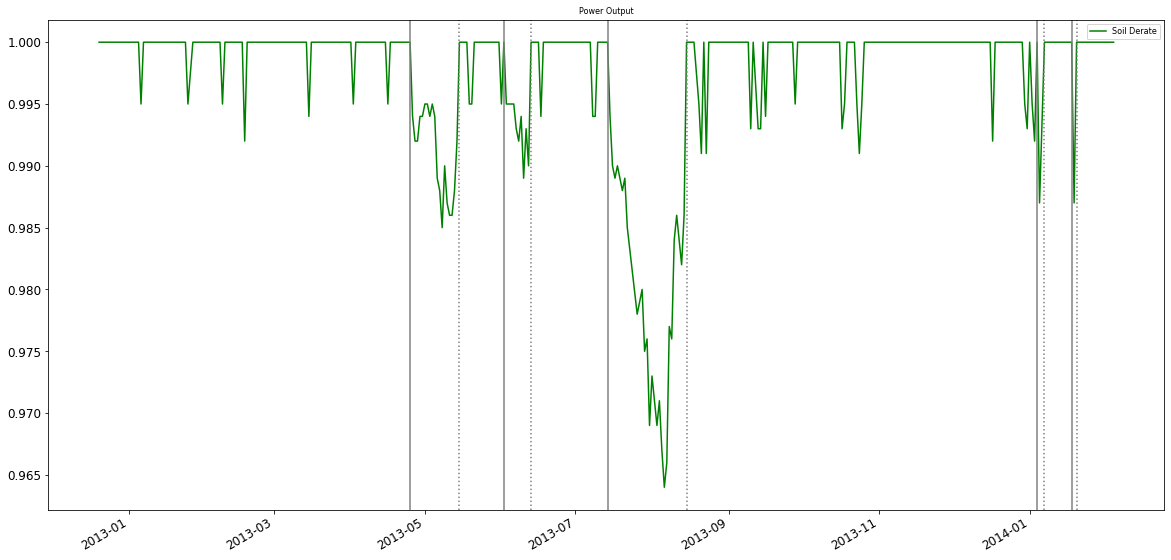

In [4]:
x=0.989
df.soiling_derate[-1]=1
if filename=='golden.csv':
    df.soiling_derate[0]=1
    df.soiling_derate[1]=1
df.soiling_derate[-1]=1
df_soil_output=soiling_dates(df,y=x,plot=True)
# print(f'Here we observe the exact dates which a soiling interval starts and stops')
# print(df_soil_output)

#### Motifs and Genetic algorithm

We rest on the matrixprofile algortihm and more specifically in the motif calculation algorithm by creating a domain of the several parameters it holds. On top of that we use a genetic algorithm in order to optimize the aforementioned
parameters which result into fiding soiling patterns(motifs).
To evaluate our approach, we use as training/testing data any of the Eugene, Cocoa, Golden panels.

### Parameters Initialization

In the next cell we initialize our parameters for a complete genetic run.

**col**: Columns which the matrix profile will be executed

**pop_size**: Population size. In our setting we create individuals (as many as the pop_size) which consist of 6 chromosomes. Namely those chromosomes are:

*min_neighbors*: The minimum number of similar matches a subsequence needs to have in order to be considered a motif.

*max_distance*: For a candidate motif,max_distance is the maximum distance allowed between the motif and the subsequence in order to be considered as a match.

*cutoff*: The largest matrix profile value (distance) that a candidate motif is allowed to have.

*max_matches*: The maximum amount of similar matches of a motif representative to be returned.

*max_motifs*: The maximum number of motifs to return.

*matrix_profile_windows*: Window size to perform the matrix profile.

**num_parents_mating**: Selects the parents using a user defined selection technique. Later, these parents will mate to produce the offspring. The techniques offered are: Selection Mating Pool, Steady State, Rank, Random, Tournament, Roulette Wheel Selection. (num_parents_mating must be always stricter less than pop_size)

**crossover**: Applies the  crossover. It randomly selects a gene at which crossover takes place between the pairs of parents through various techniques. The techniques offered are: Single_point, Two_points, Uniform, Scatter crossover.

**num_mutations**: Mutation changes a number of genes as defined by the num_mutations argument.The changes are random. More techniques to be **updated**.

**num_generations**: Number of genereations(loops) of the algorithm.

**mix_up**: True/False If true in each loop the pareting and crossover techniques are changing randomly.



In [5]:
col=['power']
pop_size = 300
num_parents_mating = 200
num_generations = 300
num_mutations=6
days=0
mix_up=True
#parenting=[smp,sss,ranks,randoms,tournament,rws,sus]
parenting='tournament'
#crossover=[single,twopoint,uni,scatter,old]
crossover='twopoint'
events=len(df_soil_output)

The goal of the procedure is to optimize the starting population through some steps.
1. Initialazing of the starting population.
2. Calculate a fitness function. We create a binary set of soiling & motif periods. In this setting we optimize the recall function from sklearn. We denote with class "1" the soiling and the motif periods, with class "0" when we have no soiling, motif period.

3. For the best output of fitness population we create the parents
4. From parents through crossover function we create the offspring (kids)
5. In order to avoid many identical solutions we mutate the offspring
6. Last step is to pass the offspring in the population for the next generation


#### Train Step

In [6]:
new_population,best_outputs,end_df,alles_df=procedure(df,df_soil_output,pop_size,days,
                                                      num_generations,num_parents_mating,
                                                      num_mutations,col,events,parenting,
                                                      crossover,mix_up)

Features: ['power']
Chromosomes: 6
Soiling Events: 5
Generations: 300
Population :300
Parents: 200


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:21<1:47:42, 21.61s/it]

  1%|          | 2/300 [00:40<1:39:25, 20.02s/it]

  1%|          | 3/300 [01:06<1:51:41, 22.57s/it]

  1%|▏         | 4/300 [01:32<1:58:32, 24.03s/it]

  2%|▏         | 5/300 [01:58<2:01:12, 24.65s/it]

  2%|▏         | 6/300 [02:25<2:05:43, 25.66s/it]

  2%|▏         | 7/300 [02:54<2:09:49, 26.58s/it]

  3%|▎         | 8/300 [03:21<2:09:48, 26.67s/it]

  3%|▎         | 9/300 [03:49<2:12:36, 27.34s/it]

  3%|▎         | 10/300 [04:18<2:14:36, 27.85s/it]

  4%|▎         | 11/300 [04:46<2:14:07, 27.84s/it]

  4%|▍         | 12/300 [05:14<2:13:51, 27.89s/it]

  4%|▍         | 13/300 [05:42<2:12:56, 27.79s/it]

  5%|▍         | 14/300 [06:09<2:11:46, 27.65s/it]

  5%|▌         | 15/300 [06:35<2:09:05, 27.18s/it]

  5%|▌         | 16/300 [07:02<2:08:40, 27.19s/it]

  6%|▌         | 17/300 [07:30<2:08:35, 27.26s/it]

  6%|▌         | 18/300 [07:56<2:06:33, 26.93s/it]

  6%|▋         | 19/300 [08:23<2:05:33, 26.81s/it]

  7%|▋         | 20/300 [08:49<2:05:19, 26.85s/it]

  7%|▋         | 21/300 [09:15<2:02:46, 26.40s/it]

  7%|▋         | 22/300 [09:40<2:01:08, 26.14s/it]

  8%|▊         | 23/300 [10:05<1:58:54, 25.76s/it]

  8%|▊         | 24/300 [10:30<1:57:29, 25.54s/it]

  8%|▊         | 25/300 [10:54<1:54:44, 25.04s/it]

  9%|▊         | 26/300 [11:18<1:53:10, 24.78s/it]

  9%|▉         | 27/300 [11:42<1:50:59, 24.39s/it]

  9%|▉         | 28/300 [12:06<1:49:44, 24.21s/it]

 10%|▉         | 29/300 [12:32<1:52:42, 24.96s/it]

 10%|█         | 30/300 [13:00<1:55:42, 25.71s/it]

 10%|█         | 31/300 [13:26<1:55:59, 25.87s/it]

 11%|█         | 32/300 [13:53<1:57:41, 26.35s/it]

 11%|█         | 33/300 [14:21<1:58:58, 26.74s/it]

 11%|█▏        | 34/300 [14:52<2:03:40, 27.90s/it]

 12%|█▏        | 35/300 [15:24<2:09:01, 29.21s/it]

 12%|█▏        | 36/300 [15:55<2:10:46, 29.72s/it]

 12%|█▏        | 37/300 [16:26<2:12:12, 30.16s/it]

 13%|█▎        | 38/300 [17:01<2:17:25, 31.47s/it]

 13%|█▎        | 39/300 [17:35<2:21:09, 32.45s/it]

 13%|█▎        | 40/300 [18:10<2:23:44, 33.17s/it]

 14%|█▎        | 41/300 [18:45<2:24:40, 33.51s/it]

 14%|█▍        | 42/300 [19:19<2:25:32, 33.85s/it]

 14%|█▍        | 43/300 [19:53<2:24:54, 33.83s/it]

 15%|█▍        | 44/300 [20:27<2:24:02, 33.76s/it]

 15%|█▌        | 45/300 [21:02<2:25:06, 34.14s/it]

 15%|█▌        | 46/300 [21:35<2:23:54, 33.99s/it]

 16%|█▌        | 47/300 [22:10<2:24:50, 34.35s/it]

 16%|█▌        | 48/300 [22:46<2:25:24, 34.62s/it]

 16%|█▋        | 49/300 [23:22<2:26:44, 35.08s/it]

 17%|█▋        | 50/300 [24:00<2:30:39, 36.16s/it]

 17%|█▋        | 51/300 [24:39<2:32:27, 36.74s/it]

 17%|█▋        | 52/300 [25:17<2:33:26, 37.12s/it]

 18%|█▊        | 53/300 [25:55<2:34:13, 37.46s/it]

 18%|█▊        | 54/300 [26:33<2:34:56, 37.79s/it]

 18%|█▊        | 55/300 [27:12<2:35:28, 38.07s/it]

 19%|█▊        | 56/300 [27:50<2:34:33, 38.01s/it]

 19%|█▉        | 57/300 [28:27<2:32:31, 37.66s/it]

 19%|█▉        | 58/300 [29:04<2:31:39, 37.60s/it]

 20%|█▉        | 59/300 [29:42<2:31:21, 37.68s/it]

 20%|██        | 60/300 [30:19<2:29:34, 37.39s/it]

 20%|██        | 61/300 [30:54<2:26:18, 36.73s/it]

 21%|██        | 62/300 [31:32<2:26:45, 37.00s/it]

 21%|██        | 63/300 [32:10<2:27:31, 37.35s/it]

 21%|██▏       | 64/300 [32:49<2:28:51, 37.84s/it]

 22%|██▏       | 65/300 [33:27<2:28:16, 37.86s/it]

 22%|██▏       | 66/300 [34:04<2:27:20, 37.78s/it]

 22%|██▏       | 67/300 [34:42<2:26:50, 37.81s/it]

 23%|██▎       | 68/300 [35:20<2:25:43, 37.69s/it]

 23%|██▎       | 69/300 [35:57<2:25:07, 37.69s/it]

 23%|██▎       | 70/300 [36:35<2:24:45, 37.76s/it]

 24%|██▎       | 71/300 [37:15<2:26:02, 38.26s/it]

 24%|██▍       | 72/300 [37:54<2:26:21, 38.52s/it]

 24%|██▍       | 73/300 [38:33<2:26:50, 38.81s/it]

 25%|██▍       | 74/300 [39:12<2:25:40, 38.68s/it]

 25%|██▌       | 75/300 [39:50<2:24:15, 38.47s/it]

 25%|██▌       | 76/300 [40:29<2:24:16, 38.64s/it]

 26%|██▌       | 77/300 [41:06<2:22:27, 38.33s/it]

 26%|██▌       | 78/300 [41:47<2:24:03, 38.94s/it]

 26%|██▋       | 79/300 [42:26<2:24:06, 39.12s/it]

 27%|██▋       | 80/300 [43:06<2:24:11, 39.33s/it]

 27%|██▋       | 81/300 [43:45<2:23:35, 39.34s/it]

 27%|██▋       | 82/300 [44:24<2:22:40, 39.27s/it]

 28%|██▊       | 83/300 [45:03<2:20:43, 38.91s/it]

 28%|██▊       | 84/300 [45:41<2:19:51, 38.85s/it]

 28%|██▊       | 85/300 [46:20<2:19:15, 38.87s/it]

 29%|██▊       | 86/300 [46:59<2:18:06, 38.72s/it]

 29%|██▉       | 87/300 [47:35<2:15:33, 38.18s/it]

 29%|██▉       | 88/300 [48:13<2:14:26, 38.05s/it]

 30%|██▉       | 89/300 [48:51<2:13:28, 37.95s/it]

 30%|███       | 90/300 [49:27<2:11:09, 37.47s/it]

 30%|███       | 91/300 [50:04<2:09:46, 37.25s/it]

 31%|███       | 92/300 [50:45<2:13:18, 38.46s/it]

 31%|███       | 93/300 [51:25<2:14:27, 38.97s/it]

 31%|███▏      | 94/300 [52:06<2:15:12, 39.38s/it]

 32%|███▏      | 95/300 [52:46<2:14:55, 39.49s/it]

 32%|███▏      | 96/300 [53:25<2:13:54, 39.39s/it]

 32%|███▏      | 97/300 [54:04<2:12:48, 39.26s/it]

 33%|███▎      | 98/300 [54:43<2:12:02, 39.22s/it]

 33%|███▎      | 99/300 [55:22<2:11:25, 39.23s/it]

 33%|███▎      | 100/300 [56:00<2:09:54, 38.97s/it]

 34%|███▎      | 101/300 [56:38<2:07:59, 38.59s/it]

 34%|███▍      | 102/300 [57:17<2:07:30, 38.64s/it]

 34%|███▍      | 103/300 [57:56<2:07:26, 38.81s/it]

 35%|███▍      | 104/300 [58:37<2:09:12, 39.55s/it]

 35%|███▌      | 105/300 [59:17<2:09:00, 39.69s/it]

 35%|███▌      | 106/300 [59:58<2:08:51, 39.85s/it]

 36%|███▌      | 107/300 [1:00:38<2:08:28, 39.94s/it]

 36%|███▌      | 108/300 [1:01:18<2:08:09, 40.05s/it]

 36%|███▋      | 109/300 [1:01:58<2:07:09, 39.95s/it]

 37%|███▋      | 110/300 [1:02:37<2:05:53, 39.75s/it]

 37%|███▋      | 111/300 [1:03:16<2:04:05, 39.40s/it]

 37%|███▋      | 112/300 [1:03:57<2:05:28, 40.05s/it]

 38%|███▊      | 113/300 [1:04:38<2:05:22, 40.23s/it]

 38%|███▊      | 114/300 [1:05:19<2:05:58, 40.63s/it]

 38%|███▊      | 115/300 [1:06:01<2:06:05, 40.90s/it]

 39%|███▊      | 116/300 [1:06:43<2:06:07, 41.13s/it]

 39%|███▉      | 117/300 [1:07:24<2:05:23, 41.11s/it]

 39%|███▉      | 118/300 [1:08:06<2:05:52, 41.50s/it]

 40%|███▉      | 119/300 [1:08:49<2:06:02, 41.78s/it]

 40%|████      | 120/300 [1:09:31<2:05:46, 41.93s/it]

 40%|████      | 121/300 [1:10:14<2:05:55, 42.21s/it]

 41%|████      | 122/300 [1:10:56<2:04:55, 42.11s/it]

 41%|████      | 123/300 [1:11:39<2:05:03, 42.39s/it]

 41%|████▏     | 124/300 [1:12:22<2:05:13, 42.69s/it]

 42%|████▏     | 125/300 [1:13:05<2:05:07, 42.90s/it]

 42%|████▏     | 126/300 [1:13:47<2:03:40, 42.65s/it]

 42%|████▏     | 127/300 [1:14:30<2:03:14, 42.74s/it]

 43%|████▎     | 128/300 [1:15:13<2:02:11, 42.63s/it]

 43%|████▎     | 129/300 [1:15:55<2:01:29, 42.63s/it]

 43%|████▎     | 130/300 [1:16:37<2:00:14, 42.44s/it]

 44%|████▎     | 131/300 [1:17:19<1:58:40, 42.13s/it]

 44%|████▍     | 132/300 [1:18:01<1:58:19, 42.26s/it]

 44%|████▍     | 133/300 [1:18:44<1:57:56, 42.37s/it]

 45%|████▍     | 134/300 [1:19:25<1:56:21, 42.06s/it]

 45%|████▌     | 135/300 [1:20:08<1:55:49, 42.12s/it]

 45%|████▌     | 136/300 [1:20:51<1:55:58, 42.43s/it]

 46%|████▌     | 137/300 [1:21:33<1:55:29, 42.52s/it]

 46%|████▌     | 138/300 [1:22:16<1:54:56, 42.57s/it]

 46%|████▋     | 139/300 [1:23:00<1:55:30, 43.04s/it]

 47%|████▋     | 140/300 [1:23:43<1:54:39, 43.00s/it]

 47%|████▋     | 141/300 [1:24:26<1:53:36, 42.87s/it]

 47%|████▋     | 142/300 [1:25:08<1:52:29, 42.72s/it]

 48%|████▊     | 143/300 [1:25:50<1:51:23, 42.57s/it]

 48%|████▊     | 144/300 [1:26:34<1:51:25, 42.85s/it]

 48%|████▊     | 145/300 [1:27:23<1:55:18, 44.64s/it]

 49%|████▊     | 146/300 [1:28:06<1:53:54, 44.38s/it]

 49%|████▉     | 147/300 [1:28:51<1:53:19, 44.44s/it]

 49%|████▉     | 148/300 [1:29:35<1:52:03, 44.23s/it]

 50%|████▉     | 149/300 [1:30:18<1:50:53, 44.06s/it]

 50%|█████     | 150/300 [1:31:02<1:49:57, 43.98s/it]

 50%|█████     | 151/300 [1:31:46<1:49:17, 44.01s/it]

 51%|█████     | 152/300 [1:32:31<1:48:45, 44.09s/it]

 51%|█████     | 153/300 [1:33:13<1:46:56, 43.65s/it]

 51%|█████▏    | 154/300 [1:33:57<1:46:15, 43.67s/it]

 52%|█████▏    | 155/300 [1:34:39<1:44:41, 43.32s/it]

 52%|█████▏    | 156/300 [1:35:22<1:43:11, 43.00s/it]

 52%|█████▏    | 157/300 [1:36:05<1:42:29, 43.00s/it]

 53%|█████▎    | 158/300 [1:36:48<1:42:10, 43.18s/it]

 53%|█████▎    | 159/300 [1:37:32<1:41:46, 43.31s/it]

 53%|█████▎    | 160/300 [1:38:15<1:41:13, 43.38s/it]

 54%|█████▎    | 161/300 [1:38:59<1:40:25, 43.35s/it]

 54%|█████▍    | 162/300 [1:39:42<1:39:22, 43.21s/it]

 54%|█████▍    | 163/300 [1:40:24<1:38:12, 43.01s/it]

 55%|█████▍    | 164/300 [1:41:08<1:37:53, 43.18s/it]

 55%|█████▌    | 165/300 [1:41:49<1:36:00, 42.67s/it]

 55%|█████▌    | 166/300 [1:42:31<1:34:43, 42.42s/it]

 56%|█████▌    | 167/300 [1:43:14<1:34:12, 42.50s/it]

 56%|█████▌    | 168/300 [1:43:57<1:34:14, 42.84s/it]

 56%|█████▋    | 169/300 [1:44:39<1:32:37, 42.43s/it]

 57%|█████▋    | 170/300 [1:45:22<1:32:28, 42.68s/it]

 57%|█████▋    | 171/300 [1:46:05<1:32:02, 42.81s/it]

 57%|█████▋    | 172/300 [1:46:47<1:30:50, 42.58s/it]

 58%|█████▊    | 173/300 [1:47:29<1:29:54, 42.48s/it]

 58%|█████▊    | 174/300 [1:48:12<1:29:00, 42.39s/it]

 58%|█████▊    | 175/300 [1:48:57<1:30:10, 43.28s/it]

 59%|█████▊    | 176/300 [1:49:42<1:30:42, 43.89s/it]

 59%|█████▉    | 177/300 [1:50:27<1:30:30, 44.15s/it]

 59%|█████▉    | 178/300 [1:51:13<1:30:34, 44.54s/it]

 60%|█████▉    | 179/300 [1:51:58<1:30:10, 44.71s/it]

 60%|██████    | 180/300 [1:52:43<1:29:47, 44.89s/it]

 60%|██████    | 181/300 [1:53:28<1:29:21, 45.05s/it]

 61%|██████    | 182/300 [1:54:13<1:28:26, 44.97s/it]

 61%|██████    | 183/300 [1:54:58<1:27:28, 44.86s/it]

 61%|██████▏   | 184/300 [1:55:43<1:26:43, 44.86s/it]

 62%|██████▏   | 185/300 [1:56:28<1:26:04, 44.91s/it]

 62%|██████▏   | 186/300 [1:57:12<1:25:05, 44.79s/it]

 62%|██████▏   | 187/300 [1:57:55<1:23:18, 44.24s/it]

 63%|██████▎   | 188/300 [1:58:38<1:21:58, 43.92s/it]

 63%|██████▎   | 189/300 [1:59:19<1:19:17, 42.86s/it]

 63%|██████▎   | 190/300 [2:00:00<1:17:31, 42.29s/it]

 64%|██████▎   | 191/300 [2:00:42<1:16:56, 42.35s/it]

 64%|██████▍   | 192/300 [2:01:25<1:16:18, 42.40s/it]

 64%|██████▍   | 193/300 [2:02:04<1:14:05, 41.55s/it]

 65%|██████▍   | 194/300 [2:02:44<1:12:28, 41.03s/it]

 65%|██████▌   | 195/300 [2:03:26<1:12:04, 41.19s/it]

 65%|██████▌   | 196/300 [2:04:08<1:12:05, 41.60s/it]

 66%|██████▌   | 197/300 [2:04:50<1:11:20, 41.56s/it]

 66%|██████▌   | 198/300 [2:05:31<1:10:30, 41.47s/it]

 66%|██████▋   | 199/300 [2:06:11<1:09:06, 41.05s/it]

 67%|██████▋   | 200/300 [2:06:51<1:07:42, 40.62s/it]

 67%|██████▋   | 201/300 [2:07:29<1:06:06, 40.07s/it]

 67%|██████▋   | 202/300 [2:08:08<1:04:46, 39.66s/it]

 68%|██████▊   | 203/300 [2:08:46<1:03:32, 39.30s/it]

 68%|██████▊   | 204/300 [2:09:27<1:03:27, 39.66s/it]

 68%|██████▊   | 205/300 [2:10:04<1:01:39, 38.94s/it]

 69%|██████▊   | 206/300 [2:10:45<1:01:49, 39.46s/it]

 69%|██████▉   | 207/300 [2:11:20<59:18, 38.27s/it]  

 69%|██████▉   | 208/300 [2:11:56<57:15, 37.34s/it]

 70%|██████▉   | 209/300 [2:12:32<56:08, 37.02s/it]

 70%|███████   | 210/300 [2:13:07<54:41, 36.46s/it]

 70%|███████   | 211/300 [2:13:42<53:36, 36.14s/it]

 71%|███████   | 212/300 [2:14:18<52:43, 35.95s/it]

 71%|███████   | 213/300 [2:14:52<51:25, 35.46s/it]

 71%|███████▏  | 214/300 [2:15:26<50:16, 35.08s/it]

 72%|███████▏  | 215/300 [2:16:01<49:21, 34.84s/it]

 72%|███████▏  | 216/300 [2:16:39<50:05, 35.78s/it]

 72%|███████▏  | 217/300 [2:17:16<50:19, 36.38s/it]

 73%|███████▎  | 218/300 [2:17:55<50:26, 36.91s/it]

 73%|███████▎  | 219/300 [2:18:32<50:13, 37.20s/it]

 73%|███████▎  | 220/300 [2:19:10<49:42, 37.29s/it]

 74%|███████▎  | 221/300 [2:19:47<49:10, 37.34s/it]

 74%|███████▍  | 222/300 [2:20:25<48:27, 37.27s/it]

 74%|███████▍  | 223/300 [2:20:59<46:43, 36.41s/it]

 75%|███████▍  | 224/300 [2:21:36<46:14, 36.50s/it]

 75%|███████▌  | 225/300 [2:22:14<46:23, 37.11s/it]

 75%|███████▌  | 226/300 [2:22:51<45:32, 36.93s/it]

 76%|███████▌  | 227/300 [2:23:27<44:36, 36.66s/it]

 76%|███████▌  | 228/300 [2:24:04<44:02, 36.70s/it]

 76%|███████▋  | 229/300 [2:24:40<43:24, 36.69s/it]

 77%|███████▋  | 230/300 [2:25:18<43:19, 37.13s/it]

 77%|███████▋  | 231/300 [2:25:56<42:56, 37.33s/it]

 77%|███████▋  | 232/300 [2:26:36<43:07, 38.06s/it]

 78%|███████▊  | 233/300 [2:27:15<42:52, 38.39s/it]

 78%|███████▊  | 234/300 [2:27:55<42:36, 38.73s/it]

 78%|███████▊  | 235/300 [2:28:33<41:53, 38.67s/it]

 79%|███████▊  | 236/300 [2:29:11<41:05, 38.53s/it]

 79%|███████▉  | 237/300 [2:29:50<40:29, 38.57s/it]

 79%|███████▉  | 238/300 [2:30:30<40:25, 39.12s/it]

 80%|███████▉  | 239/300 [2:31:10<40:02, 39.39s/it]

 80%|████████  | 240/300 [2:31:51<39:38, 39.64s/it]

 80%|████████  | 241/300 [2:32:31<39:14, 39.91s/it]

 81%|████████  | 242/300 [2:33:12<38:44, 40.07s/it]

 81%|████████  | 243/300 [2:33:52<38:02, 40.04s/it]

 81%|████████▏ | 244/300 [2:34:34<38:03, 40.78s/it]

 82%|████████▏ | 245/300 [2:35:16<37:40, 41.09s/it]

 82%|████████▏ | 246/300 [2:36:00<37:43, 41.92s/it]

 82%|████████▏ | 247/300 [2:36:41<36:57, 41.84s/it]

 83%|████████▎ | 248/300 [2:37:24<36:19, 41.92s/it]

 83%|████████▎ | 249/300 [2:38:05<35:37, 41.91s/it]

 83%|████████▎ | 250/300 [2:38:48<35:05, 42.10s/it]

 84%|████████▎ | 251/300 [2:39:30<34:16, 41.97s/it]

 84%|████████▍ | 252/300 [2:40:11<33:25, 41.77s/it]

 84%|████████▍ | 253/300 [2:40:55<33:10, 42.35s/it]

 85%|████████▍ | 254/300 [2:41:39<32:58, 43.00s/it]

 85%|████████▌ | 255/300 [2:42:22<32:16, 43.03s/it]

 85%|████████▌ | 256/300 [2:43:06<31:42, 43.24s/it]

 86%|████████▌ | 257/300 [2:43:50<31:13, 43.56s/it]

 86%|████████▌ | 258/300 [2:44:35<30:47, 44.00s/it]

 86%|████████▋ | 259/300 [2:45:20<30:15, 44.29s/it]

 87%|████████▋ | 260/300 [2:46:04<29:21, 44.05s/it]

 87%|████████▋ | 261/300 [2:46:44<27:56, 42.99s/it]

 87%|████████▋ | 262/300 [2:47:26<27:01, 42.66s/it]

 88%|████████▊ | 263/300 [2:48:08<26:05, 42.30s/it]

 88%|████████▊ | 264/300 [2:48:50<25:19, 42.21s/it]

 88%|████████▊ | 265/300 [2:49:33<24:45, 42.45s/it]

 89%|████████▊ | 266/300 [2:50:18<24:28, 43.18s/it]

 89%|████████▉ | 267/300 [2:50:58<23:19, 42.40s/it]

 89%|████████▉ | 268/300 [2:51:38<22:15, 41.73s/it]

 90%|████████▉ | 269/300 [2:52:20<21:32, 41.69s/it]

 90%|█████████ | 270/300 [2:53:00<20:37, 41.26s/it]

 90%|█████████ | 271/300 [2:53:41<19:51, 41.09s/it]

 91%|█████████ | 272/300 [2:54:20<18:53, 40.50s/it]

 91%|█████████ | 273/300 [2:54:59<18:03, 40.13s/it]

 91%|█████████▏| 274/300 [2:55:39<17:21, 40.05s/it]

 92%|█████████▏| 275/300 [2:56:22<16:59, 40.79s/it]

 92%|█████████▏| 276/300 [2:57:04<16:34, 41.42s/it]

 92%|█████████▏| 277/300 [2:57:46<15:53, 41.48s/it]

 93%|█████████▎| 278/300 [2:58:27<15:07, 41.23s/it]

 93%|█████████▎| 279/300 [2:59:16<15:18, 43.76s/it]

 93%|█████████▎| 280/300 [2:59:56<14:09, 42.45s/it]

 94%|█████████▎| 281/300 [3:00:35<13:07, 41.45s/it]

 94%|█████████▍| 282/300 [3:01:14<12:15, 40.86s/it]

 94%|█████████▍| 283/300 [3:01:54<11:29, 40.57s/it]

 95%|█████████▍| 284/300 [3:02:35<10:51, 40.73s/it]

 95%|█████████▌| 285/300 [3:03:18<10:18, 41.21s/it]

 95%|█████████▌| 286/300 [3:03:59<09:36, 41.19s/it]

 96%|█████████▌| 287/300 [3:04:40<08:53, 41.08s/it]

 96%|█████████▌| 288/300 [3:05:20<08:10, 40.88s/it]

 96%|█████████▋| 289/300 [3:06:00<07:25, 40.52s/it]

 97%|█████████▋| 290/300 [3:06:40<06:45, 40.51s/it]

 97%|█████████▋| 291/300 [3:07:22<06:06, 40.75s/it]

 97%|█████████▋| 292/300 [3:08:05<05:32, 41.56s/it]

 98%|█████████▊| 293/300 [3:08:47<04:51, 41.61s/it]

 98%|█████████▊| 294/300 [3:09:28<04:09, 41.60s/it]

 98%|█████████▊| 295/300 [3:10:09<03:26, 41.39s/it]

 99%|█████████▊| 296/300 [3:10:50<02:45, 41.28s/it]

 99%|█████████▉| 297/300 [3:11:35<02:06, 42.28s/it]

 99%|█████████▉| 298/300 [3:12:21<01:26, 43.38s/it]

100%|█████████▉| 299/300 [3:13:03<00:43, 43.01s/it]

100%|██████████| 300/300 [3:13:58<00:00, 46.75s/it]

100%|██████████| 300/300 [3:13:58<00:00, 38.80s/it]

Time to complete: 11638.93seconds


:The individual which max the F1 function is: 69
Best solution fitness :  0.7272727272727274


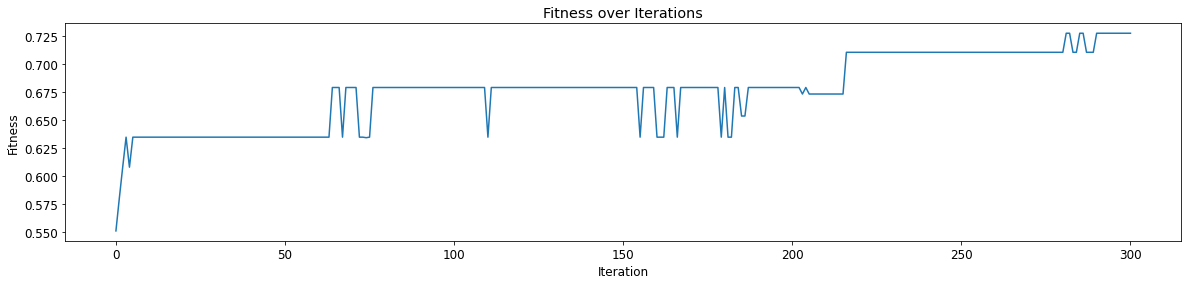

Shape of Result Frame
(1439, 17)


In [7]:
# print(best_outputs)
fitness,alles_df1 = fiteness_fun(df,df_soil_output,days,new_population,col)
best_outputs.extend([np.max(fitness)])
# Then return the index of that solution corresponding to the best fitness.
best_match_idx = np.where(fitness == np.max(fitness))
print(f':The individual which max the F1 function is: {len(best_match_idx[0])}')
print("Best solution fitness : ", np.max(best_outputs))
import matplotlib.pyplot
matplotlib.pyplot.plot(best_outputs)
matplotlib.pyplot.title('Fitness over Iterations')
matplotlib.pyplot.xlabel("Iteration")
matplotlib.pyplot.ylabel("Fitness")
matplotlib.pyplot.show()
end_df=pd.concat([end_df,alles_df1])
end_df=end_df.reset_index(drop=True)
end_df=end_df.loc[end_df[['f1']].drop_duplicates(['f1']).index]
end_df=end_df.sort_values(by='f1',ascending=False)
end_df=end_df.reset_index(drop=True)
end_df.head(5)
print('Shape of Result Frame')
print(end_df.shape)

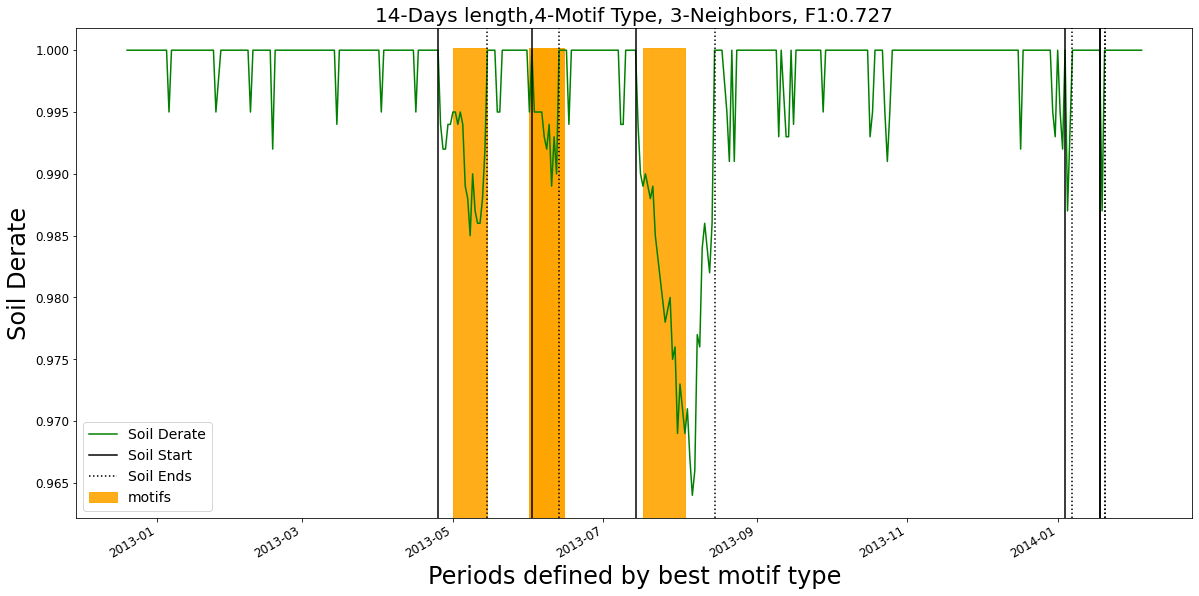

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95       302
         1.0       0.95      0.59      0.73        68

    accuracy                           0.92       370
   macro avg       0.93      0.79      0.84       370
weighted avg       0.92      0.92      0.91       370



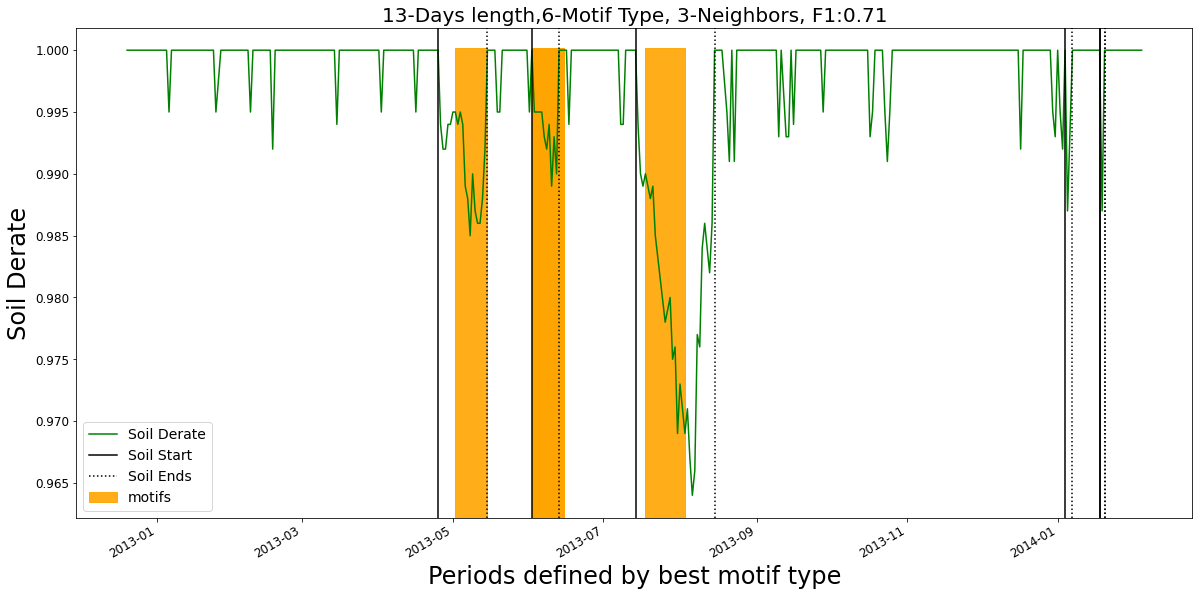

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       302
         1.0       0.97      0.56      0.71        68

    accuracy                           0.92       370
   macro avg       0.94      0.78      0.83       370
weighted avg       0.92      0.92      0.91       370



In [8]:
motif_graph_multi_dim(col=col,df=df,
                  df_soil_output=df_soil_output,
                  alles_df=end_df,n=2,plot=True)

### Motif Based Pattern Discovery
Here we test the results of the the previous panel to the other two.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
1/2
golden.csv
We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (242, 7)
We found 9 Soiling Events with decay less than 0.989 


  0%|          | 0/569 [00:00<?, ?it/s]

  0%|          | 1/569 [00:00<02:38,  3.59it/s]

  0%|          | 2/569 [00:00<03:26,  2.74it/s]

  1%|          | 3/569 [00:01<03:46,  2.50it/s]

  1%|          | 4/569 [00:01<02:48,  3.36it/s]

  1%|          | 5/569 [00:01<03:31,  2.67it/s]

  1%|          | 7/569 [00:02<02:44,  3.41it/s]

  1%|▏         | 8/569 [00:03<03:59,  2.34it/s]

  2%|▏         | 9/569 [00:03<05:21,  1.74it/s]

  2%|▏         | 10/569 [00:04<04:54,  1.90it/s]

  2%|▏         | 11/569 [00:04<04:48,  1.94it/s]

  2%|▏         | 12/569 [00:05<03:46,  2.46it/s]

  2%|▏         | 13/569 [00:05<04:56,  1.88it/s]

  2%|▏         | 14/569 [00:06<05:49,  1.59it/s]

  3%|▎         | 15/569 [00:07<04:57,  1.86it/s]

  3%|▎         | 16/569 [00:07<04:23,  2.10it/s]

  3%|▎         | 17/569 [00:08<05:01,  1.83it/s]

  3%|▎         | 18/569 [00:08<04:15,  2.16it/s]

  3%|▎         | 19/569 [00:08<04:08,  2.21it/s]

  4%|▎         | 20/569 [00:09<05:07,  1.79it/s]

  4%|▎         | 21/569 [00:10<05:50,  1.56it/s]

  4%|▍         | 22/569 [00:11<06:21,  1.43it/s]

  4%|▍         | 23/569 [00:11<05:17,  1.72it/s]

  4%|▍         | 24/569 [00:11<04:04,  2.23it/s]

  4%|▍         | 25/569 [00:12<04:24,  2.06it/s]

  5%|▍         | 26/569 [00:12<04:18,  2.10it/s]

  5%|▍         | 27/569 [00:13<04:10,  2.16it/s]

  5%|▍         | 28/569 [00:14<06:57,  1.30it/s]

  5%|▌         | 29/569 [00:15<05:57,  1.51it/s]

  5%|▌         | 30/569 [00:15<04:53,  1.83it/s]

  5%|▌         | 31/569 [00:15<05:08,  1.74it/s]

  6%|▌         | 32/569 [00:16<04:24,  2.03it/s]

  6%|▌         | 33/569 [00:16<03:27,  2.58it/s]

  6%|▌         | 34/569 [00:16<03:42,  2.40it/s]

  6%|▌         | 35/569 [00:17<03:47,  2.34it/s]

  6%|▋         | 36/569 [00:17<03:15,  2.73it/s]

  7%|▋         | 37/569 [00:18<04:10,  2.13it/s]

  7%|▋         | 38/569 [00:18<04:24,  2.01it/s]

  7%|▋         | 39/569 [00:19<04:45,  1.86it/s]

  7%|▋         | 40/569 [00:19<04:41,  1.88it/s]

  7%|▋         | 41/569 [00:20<05:29,  1.60it/s]

  7%|▋         | 42/569 [00:21<05:31,  1.59it/s]

  8%|▊         | 43/569 [00:22<05:20,  1.64it/s]

  8%|▊         | 44/569 [00:22<05:41,  1.54it/s]

  8%|▊         | 45/569 [00:23<04:54,  1.78it/s]

  8%|▊         | 46/569 [00:24<07:20,  1.19it/s]

  8%|▊         | 47/569 [00:25<07:26,  1.17it/s]

  8%|▊         | 48/569 [00:26<08:41,  1.00s/it]

  9%|▊         | 49/569 [00:28<09:36,  1.11s/it]

  9%|▉         | 50/569 [00:29<09:38,  1.12s/it]

  9%|▉         | 51/569 [00:29<07:50,  1.10it/s]

  9%|▉         | 52/569 [00:30<07:20,  1.17it/s]

  9%|▉         | 53/569 [00:30<05:59,  1.44it/s]

  9%|▉         | 54/569 [00:31<05:36,  1.53it/s]

 10%|▉         | 55/569 [00:32<05:52,  1.46it/s]

 10%|▉         | 56/569 [00:32<05:34,  1.54it/s]

 10%|█         | 57/569 [00:33<05:55,  1.44it/s]

 10%|█         | 58/569 [00:34<07:03,  1.21it/s]

 10%|█         | 59/569 [00:35<07:18,  1.16it/s]

 11%|█         | 60/569 [00:36<07:20,  1.16it/s]

 11%|█         | 61/569 [00:37<07:26,  1.14it/s]

 11%|█         | 62/569 [00:37<05:57,  1.42it/s]

 11%|█         | 63/569 [00:38<05:43,  1.47it/s]

 11%|█         | 64/569 [00:39<05:49,  1.44it/s]

 11%|█▏        | 65/569 [00:39<05:50,  1.44it/s]

 12%|█▏        | 66/569 [00:40<05:14,  1.60it/s]

 12%|█▏        | 67/569 [00:40<05:09,  1.62it/s]

 12%|█▏        | 68/569 [00:41<05:12,  1.61it/s]

 12%|█▏        | 69/569 [00:43<07:46,  1.07it/s]

 12%|█▏        | 70/569 [00:44<09:20,  1.12s/it]

 12%|█▏        | 71/569 [00:45<08:40,  1.04s/it]

 13%|█▎        | 72/569 [00:46<07:58,  1.04it/s]

 13%|█▎        | 73/569 [00:46<07:05,  1.16it/s]

 13%|█▎        | 74/569 [00:47<05:51,  1.41it/s]

 13%|█▎        | 75/569 [00:47<05:20,  1.54it/s]

 13%|█▎        | 76/569 [00:48<05:38,  1.46it/s]

 14%|█▎        | 77/569 [00:48<04:54,  1.67it/s]

 14%|█▎        | 78/569 [00:49<04:33,  1.79it/s]

 14%|█▍        | 79/569 [00:49<03:45,  2.17it/s]

 14%|█▍        | 80/569 [00:50<04:20,  1.87it/s]

 14%|█▍        | 81/569 [00:50<04:38,  1.75it/s]

 14%|█▍        | 82/569 [00:51<04:28,  1.81it/s]

 15%|█▍        | 83/569 [00:52<04:28,  1.81it/s]

 15%|█▍        | 84/569 [00:52<04:25,  1.82it/s]

 15%|█▍        | 85/569 [00:53<04:08,  1.95it/s]

 15%|█▌        | 86/569 [00:54<07:06,  1.13it/s]

 15%|█▌        | 87/569 [00:55<06:51,  1.17it/s]

 15%|█▌        | 88/569 [00:56<05:58,  1.34it/s]

 16%|█▌        | 89/569 [00:56<05:32,  1.44it/s]

 16%|█▌        | 90/569 [00:57<06:15,  1.28it/s]

 16%|█▌        | 91/569 [00:58<06:20,  1.26it/s]

 16%|█▌        | 92/569 [00:59<06:39,  1.19it/s]

 16%|█▋        | 93/569 [01:00<07:07,  1.11it/s]

 17%|█▋        | 94/569 [01:00<05:47,  1.37it/s]

 17%|█▋        | 95/569 [01:01<06:48,  1.16it/s]

 17%|█▋        | 96/569 [01:03<08:40,  1.10s/it]

 17%|█▋        | 97/569 [01:04<07:37,  1.03it/s]

 17%|█▋        | 98/569 [01:05<07:10,  1.09it/s]

 17%|█▋        | 99/569 [01:05<06:32,  1.20it/s]

 18%|█▊        | 100/569 [01:06<05:40,  1.38it/s]

 18%|█▊        | 101/569 [01:07<06:12,  1.26it/s]

 18%|█▊        | 102/569 [01:07<05:01,  1.55it/s]

 18%|█▊        | 103/569 [01:07<03:54,  1.98it/s]

 18%|█▊        | 104/569 [01:08<04:13,  1.84it/s]

 18%|█▊        | 105/569 [01:08<03:46,  2.05it/s]

 19%|█▊        | 106/569 [01:09<04:13,  1.83it/s]

 19%|█▉        | 107/569 [01:09<04:12,  1.83it/s]

 19%|█▉        | 108/569 [01:10<04:29,  1.71it/s]

 19%|█▉        | 109/569 [01:10<04:04,  1.88it/s]

 19%|█▉        | 110/569 [01:11<03:34,  2.14it/s]

 20%|█▉        | 111/569 [01:11<03:50,  1.99it/s]

 20%|█▉        | 112/569 [01:12<03:26,  2.21it/s]

 20%|█▉        | 113/569 [01:12<04:22,  1.73it/s]

 20%|██        | 114/569 [01:14<06:24,  1.18it/s]

 20%|██        | 115/569 [01:14<05:30,  1.37it/s]

 20%|██        | 116/569 [01:15<05:02,  1.50it/s]

 21%|██        | 117/569 [01:16<04:51,  1.55it/s]

 21%|██        | 118/569 [01:17<05:48,  1.29it/s]

 21%|██        | 119/569 [01:17<05:57,  1.26it/s]

 21%|██        | 120/569 [01:18<06:07,  1.22it/s]

 21%|██▏       | 121/569 [01:19<05:53,  1.27it/s]

 21%|██▏       | 122/569 [01:20<06:38,  1.12it/s]

 22%|██▏       | 123/569 [01:21<07:15,  1.02it/s]

 22%|██▏       | 124/569 [01:24<11:34,  1.56s/it]

 22%|██▏       | 125/569 [01:25<08:46,  1.19s/it]

 22%|██▏       | 126/569 [01:25<08:04,  1.09s/it]

 22%|██▏       | 127/569 [01:27<09:45,  1.32s/it]

 22%|██▏       | 128/569 [01:29<10:13,  1.39s/it]

 23%|██▎       | 129/569 [01:31<11:20,  1.55s/it]

 23%|██▎       | 130/569 [01:33<11:50,  1.62s/it]

 23%|██▎       | 131/569 [01:34<11:13,  1.54s/it]

 23%|██▎       | 132/569 [01:36<13:08,  1.80s/it]

 23%|██▎       | 133/569 [01:40<16:18,  2.24s/it]

 24%|██▎       | 134/569 [01:44<21:20,  2.94s/it]

 24%|██▎       | 135/569 [01:45<16:40,  2.31s/it]

 24%|██▍       | 136/569 [01:46<13:17,  1.84s/it]

 24%|██▍       | 137/569 [01:56<32:04,  4.46s/it]

 24%|██▍       | 138/569 [02:07<45:29,  6.33s/it]

 24%|██▍       | 139/569 [02:09<35:29,  4.95s/it]

 25%|██▍       | 140/569 [02:12<32:46,  4.58s/it]

 25%|██▍       | 141/569 [02:14<27:01,  3.79s/it]

 25%|██▍       | 142/569 [02:15<20:20,  2.86s/it]

 25%|██▌       | 143/569 [02:16<16:20,  2.30s/it]

 25%|██▌       | 144/569 [02:17<13:12,  1.86s/it]

 25%|██▌       | 145/569 [02:18<10:28,  1.48s/it]

 26%|██▌       | 146/569 [02:19<09:26,  1.34s/it]

 26%|██▌       | 147/569 [02:20<08:40,  1.23s/it]

 26%|██▌       | 148/569 [02:21<09:12,  1.31s/it]

 26%|██▌       | 149/569 [02:22<09:06,  1.30s/it]

 26%|██▋       | 150/569 [02:24<09:15,  1.33s/it]

 27%|██▋       | 151/569 [02:24<08:03,  1.16s/it]

 27%|██▋       | 152/569 [02:25<07:20,  1.06s/it]

 27%|██▋       | 153/569 [02:26<06:17,  1.10it/s]

 27%|██▋       | 154/569 [02:26<05:01,  1.38it/s]

 27%|██▋       | 155/569 [02:27<04:30,  1.53it/s]

 27%|██▋       | 156/569 [02:27<04:12,  1.64it/s]

 28%|██▊       | 157/569 [02:28<03:53,  1.76it/s]

 28%|██▊       | 158/569 [02:28<03:36,  1.89it/s]

 28%|██▊       | 159/569 [02:29<03:55,  1.74it/s]

 28%|██▊       | 160/569 [02:30<04:28,  1.52it/s]

 28%|██▊       | 161/569 [02:30<04:17,  1.58it/s]

 28%|██▊       | 162/569 [02:31<04:07,  1.64it/s]

 29%|██▊       | 163/569 [02:31<04:19,  1.57it/s]

 29%|██▉       | 164/569 [02:32<04:36,  1.46it/s]

 29%|██▉       | 165/569 [02:33<05:07,  1.31it/s]

 29%|██▉       | 166/569 [02:34<05:20,  1.26it/s]

 29%|██▉       | 167/569 [02:34<04:33,  1.47it/s]

 30%|██▉       | 168/569 [02:35<04:29,  1.49it/s]

 30%|██▉       | 169/569 [02:35<03:39,  1.82it/s]

 30%|██▉       | 170/569 [02:36<04:17,  1.55it/s]

 30%|███       | 171/569 [02:37<04:13,  1.57it/s]

 30%|███       | 172/569 [02:37<04:17,  1.54it/s]

 30%|███       | 173/569 [02:38<03:48,  1.73it/s]

 31%|███       | 174/569 [02:39<04:12,  1.56it/s]

 31%|███       | 175/569 [02:39<03:27,  1.90it/s]

 31%|███       | 176/569 [02:40<03:46,  1.74it/s]

 31%|███       | 177/569 [02:40<04:08,  1.58it/s]

 31%|███▏      | 178/569 [02:41<03:49,  1.70it/s]

 31%|███▏      | 179/569 [02:41<03:24,  1.90it/s]

 32%|███▏      | 180/569 [02:42<03:10,  2.05it/s]

 32%|███▏      | 181/569 [02:43<04:19,  1.50it/s]

 32%|███▏      | 182/569 [02:44<05:10,  1.24it/s]

 32%|███▏      | 183/569 [02:45<05:22,  1.20it/s]

 32%|███▏      | 184/569 [02:45<04:46,  1.35it/s]

 33%|███▎      | 185/569 [02:46<04:36,  1.39it/s]

 33%|███▎      | 186/569 [02:46<03:59,  1.60it/s]

 33%|███▎      | 187/569 [02:47<04:01,  1.58it/s]

 33%|███▎      | 188/569 [02:48<04:37,  1.37it/s]

 33%|███▎      | 189/569 [02:49<04:43,  1.34it/s]

 33%|███▎      | 190/569 [02:49<04:15,  1.48it/s]

 34%|███▎      | 191/569 [02:50<04:30,  1.40it/s]

 34%|███▎      | 192/569 [02:51<03:56,  1.60it/s]

 34%|███▍      | 193/569 [02:51<04:29,  1.39it/s]

 34%|███▍      | 194/569 [02:52<04:41,  1.33it/s]

 34%|███▍      | 195/569 [02:53<03:53,  1.60it/s]

 34%|███▍      | 196/569 [02:54<05:07,  1.21it/s]

 35%|███▍      | 197/569 [02:54<04:34,  1.36it/s]

 35%|███▍      | 198/569 [02:55<04:48,  1.29it/s]

 35%|███▍      | 199/569 [02:56<04:22,  1.41it/s]

 35%|███▌      | 200/569 [02:56<04:07,  1.49it/s]

 35%|███▌      | 201/569 [02:57<04:13,  1.45it/s]

 36%|███▌      | 202/569 [02:58<04:08,  1.48it/s]

 36%|███▌      | 203/569 [02:59<04:32,  1.34it/s]

 36%|███▌      | 204/569 [02:59<04:24,  1.38it/s]

 36%|███▌      | 205/569 [03:00<04:38,  1.31it/s]

 36%|███▌      | 206/569 [03:01<04:30,  1.34it/s]

 36%|███▋      | 207/569 [03:02<04:21,  1.39it/s]

 37%|███▋      | 208/569 [03:02<03:56,  1.52it/s]

 37%|███▋      | 209/569 [03:03<03:34,  1.68it/s]

 37%|███▋      | 210/569 [03:03<03:57,  1.51it/s]

 37%|███▋      | 211/569 [03:04<04:01,  1.48it/s]

 37%|███▋      | 212/569 [03:05<04:02,  1.47it/s]

 37%|███▋      | 213/569 [03:05<03:42,  1.60it/s]

 38%|███▊      | 214/569 [03:06<03:21,  1.77it/s]

 38%|███▊      | 215/569 [03:07<03:43,  1.58it/s]

 38%|███▊      | 216/569 [03:07<03:52,  1.52it/s]

 38%|███▊      | 217/569 [03:08<04:04,  1.44it/s]

 38%|███▊      | 218/569 [03:08<03:25,  1.70it/s]

 38%|███▊      | 219/569 [03:09<03:33,  1.64it/s]

 39%|███▊      | 220/569 [03:10<03:57,  1.47it/s]

 39%|███▉      | 221/569 [03:11<04:16,  1.36it/s]

 39%|███▉      | 222/569 [03:11<04:19,  1.34it/s]

 39%|███▉      | 223/569 [03:12<03:51,  1.50it/s]

 39%|███▉      | 224/569 [03:12<03:35,  1.60it/s]

 40%|███▉      | 225/569 [03:14<05:14,  1.09it/s]

 40%|███▉      | 226/569 [03:15<04:26,  1.29it/s]

 40%|███▉      | 227/569 [03:15<04:27,  1.28it/s]

 40%|████      | 228/569 [03:16<04:08,  1.37it/s]

 40%|████      | 229/569 [03:17<04:31,  1.25it/s]

 40%|████      | 230/569 [03:18<04:22,  1.29it/s]

 41%|████      | 231/569 [03:18<03:21,  1.68it/s]

 41%|████      | 232/569 [03:18<03:10,  1.77it/s]

 41%|████      | 233/569 [03:19<02:53,  1.93it/s]

 41%|████      | 234/569 [03:19<03:06,  1.80it/s]

 41%|████▏     | 235/569 [03:20<03:32,  1.57it/s]

 41%|████▏     | 236/569 [03:21<03:48,  1.46it/s]

 42%|████▏     | 237/569 [03:22<03:58,  1.39it/s]

 42%|████▏     | 238/569 [03:23<04:05,  1.35it/s]

 42%|████▏     | 239/569 [03:24<05:35,  1.02s/it]

 42%|████▏     | 240/569 [03:25<05:34,  1.02s/it]

 42%|████▏     | 241/569 [03:26<05:10,  1.06it/s]

 43%|████▎     | 242/569 [03:26<04:24,  1.24it/s]

 43%|████▎     | 243/569 [03:27<03:24,  1.60it/s]

 43%|████▎     | 244/569 [03:27<02:52,  1.88it/s]

 43%|████▎     | 245/569 [03:27<02:38,  2.05it/s]

 43%|████▎     | 246/569 [03:28<03:15,  1.65it/s]

 43%|████▎     | 247/569 [03:29<03:41,  1.46it/s]

 44%|████▎     | 248/569 [03:30<03:22,  1.58it/s]

 44%|████▍     | 249/569 [03:30<03:26,  1.55it/s]

 44%|████▍     | 250/569 [03:31<03:01,  1.76it/s]

 44%|████▍     | 251/569 [03:32<04:19,  1.23it/s]

 44%|████▍     | 252/569 [03:33<04:23,  1.20it/s]

 44%|████▍     | 253/569 [03:34<04:22,  1.20it/s]

 45%|████▍     | 254/569 [03:34<03:48,  1.38it/s]

 45%|████▍     | 255/569 [03:35<04:23,  1.19it/s]

 45%|████▍     | 256/569 [03:36<04:39,  1.12it/s]

 45%|████▌     | 257/569 [03:38<05:21,  1.03s/it]

 45%|████▌     | 258/569 [03:39<05:28,  1.06s/it]

 46%|████▌     | 259/569 [03:40<04:58,  1.04it/s]

 46%|████▌     | 260/569 [03:40<04:16,  1.20it/s]

 46%|████▌     | 261/569 [03:41<03:48,  1.35it/s]

 46%|████▌     | 262/569 [03:41<03:21,  1.53it/s]

 46%|████▌     | 263/569 [03:42<03:29,  1.46it/s]

 46%|████▋     | 264/569 [03:43<03:45,  1.35it/s]

 47%|████▋     | 265/569 [03:44<04:11,  1.21it/s]

 47%|████▋     | 266/569 [03:44<03:17,  1.54it/s]

 47%|████▋     | 267/569 [03:48<08:09,  1.62s/it]

 47%|████▋     | 268/569 [03:50<09:15,  1.84s/it]

 47%|████▋     | 269/569 [03:52<08:19,  1.67s/it]

 47%|████▋     | 270/569 [03:53<08:01,  1.61s/it]

 48%|████▊     | 271/569 [03:56<09:42,  1.96s/it]

 48%|████▊     | 272/569 [03:58<10:40,  2.16s/it]

 48%|████▊     | 273/569 [04:10<24:10,  4.90s/it]

 48%|████▊     | 274/569 [04:21<33:19,  6.78s/it]

 48%|████▊     | 275/569 [04:28<34:19,  7.01s/it]

 49%|████▊     | 276/569 [04:30<26:14,  5.37s/it]

 49%|████▊     | 277/569 [04:32<20:49,  4.28s/it]

 49%|████▉     | 278/569 [04:33<16:03,  3.31s/it]

 49%|████▉     | 279/569 [04:34<13:18,  2.75s/it]

 49%|████▉     | 280/569 [04:35<10:03,  2.09s/it]

 49%|████▉     | 281/569 [04:35<07:58,  1.66s/it]

 50%|████▉     | 282/569 [04:37<07:41,  1.61s/it]

 50%|████▉     | 283/569 [04:38<06:27,  1.35s/it]

 50%|████▉     | 284/569 [04:38<05:34,  1.17s/it]

 50%|█████     | 285/569 [04:39<04:58,  1.05s/it]

 50%|█████     | 286/569 [04:40<04:44,  1.00s/it]

 50%|█████     | 287/569 [04:40<03:48,  1.23it/s]

 51%|█████     | 288/569 [04:41<03:21,  1.39it/s]

 51%|█████     | 289/569 [04:41<02:53,  1.62it/s]

 51%|█████     | 290/569 [04:42<02:46,  1.68it/s]

 51%|█████     | 291/569 [04:42<02:26,  1.89it/s]

 51%|█████▏    | 292/569 [04:43<02:09,  2.13it/s]

 51%|█████▏    | 293/569 [04:44<03:32,  1.30it/s]

 52%|█████▏    | 294/569 [04:45<03:26,  1.33it/s]

 52%|█████▏    | 295/569 [04:46<03:49,  1.20it/s]

 52%|█████▏    | 296/569 [04:47<03:55,  1.16it/s]

 52%|█████▏    | 297/569 [04:47<03:16,  1.38it/s]

 52%|█████▏    | 298/569 [04:48<03:18,  1.37it/s]

 53%|█████▎    | 299/569 [04:48<03:06,  1.45it/s]

 53%|█████▎    | 300/569 [04:49<03:07,  1.44it/s]

 53%|█████▎    | 301/569 [04:50<03:19,  1.34it/s]

 53%|█████▎    | 302/569 [04:51<03:06,  1.43it/s]

 53%|█████▎    | 303/569 [04:51<02:55,  1.51it/s]

 53%|█████▎    | 304/569 [04:51<02:16,  1.93it/s]

 54%|█████▎    | 305/569 [04:52<02:21,  1.87it/s]

 54%|█████▍    | 306/569 [04:53<02:43,  1.61it/s]

 54%|█████▍    | 307/569 [04:54<03:40,  1.19it/s]

 54%|█████▍    | 308/569 [04:55<03:17,  1.32it/s]

 54%|█████▍    | 309/569 [04:55<02:43,  1.59it/s]

 54%|█████▍    | 310/569 [04:56<02:39,  1.62it/s]

 55%|█████▍    | 311/569 [04:56<02:51,  1.51it/s]

 55%|█████▍    | 312/569 [04:57<02:51,  1.50it/s]

 55%|█████▌    | 313/569 [04:58<02:48,  1.52it/s]

 55%|█████▌    | 314/569 [04:59<03:06,  1.37it/s]

 55%|█████▌    | 315/569 [04:59<03:03,  1.38it/s]

 56%|█████▌    | 316/569 [05:00<03:00,  1.40it/s]

 56%|█████▌    | 317/569 [05:01<02:57,  1.42it/s]

 56%|█████▌    | 318/569 [05:01<02:35,  1.62it/s]

 56%|█████▌    | 319/569 [05:02<02:39,  1.57it/s]

 56%|█████▌    | 320/569 [05:03<03:02,  1.37it/s]

 56%|█████▋    | 321/569 [05:04<03:53,  1.06it/s]

 57%|█████▋    | 322/569 [05:04<02:52,  1.43it/s]

 57%|█████▋    | 323/569 [05:05<02:50,  1.44it/s]

 57%|█████▋    | 324/569 [05:06<02:56,  1.39it/s]

 57%|█████▋    | 325/569 [05:06<02:59,  1.36it/s]

 57%|█████▋    | 326/569 [05:07<02:54,  1.39it/s]

 57%|█████▋    | 327/569 [05:08<02:37,  1.54it/s]

 58%|█████▊    | 328/569 [05:08<02:13,  1.80it/s]

 58%|█████▊    | 329/569 [05:09<02:17,  1.74it/s]

 58%|█████▊    | 330/569 [05:09<02:21,  1.69it/s]

 58%|█████▊    | 331/569 [05:10<02:32,  1.56it/s]

 58%|█████▊    | 332/569 [05:11<02:35,  1.53it/s]

 59%|█████▊    | 333/569 [05:11<02:34,  1.53it/s]

 59%|█████▊    | 334/569 [05:12<02:38,  1.48it/s]

 59%|█████▉    | 335/569 [05:12<02:09,  1.81it/s]

 59%|█████▉    | 336/569 [05:13<02:11,  1.77it/s]

 59%|█████▉    | 337/569 [05:14<02:21,  1.64it/s]

 59%|█████▉    | 338/569 [05:14<02:08,  1.80it/s]

 60%|█████▉    | 339/569 [05:15<02:18,  1.66it/s]

 60%|█████▉    | 340/569 [05:15<02:00,  1.90it/s]

 60%|█████▉    | 341/569 [05:16<01:59,  1.90it/s]

 60%|██████    | 342/569 [05:16<01:42,  2.21it/s]

 60%|██████    | 343/569 [05:17<02:10,  1.73it/s]

 60%|██████    | 344/569 [05:17<02:06,  1.78it/s]

 61%|██████    | 345/569 [05:18<01:58,  1.88it/s]

 61%|██████    | 346/569 [05:19<02:19,  1.60it/s]

 61%|██████    | 347/569 [05:19<02:03,  1.79it/s]

 61%|██████    | 348/569 [05:20<02:27,  1.50it/s]

 61%|██████▏   | 349/569 [05:20<02:11,  1.68it/s]

 62%|██████▏   | 350/569 [05:21<02:03,  1.77it/s]

 62%|██████▏   | 351/569 [05:22<02:27,  1.48it/s]

 62%|██████▏   | 352/569 [05:23<02:30,  1.45it/s]

 62%|██████▏   | 353/569 [05:24<03:00,  1.19it/s]

 62%|██████▏   | 354/569 [05:24<02:35,  1.38it/s]

 62%|██████▏   | 355/569 [05:25<02:22,  1.50it/s]

 63%|██████▎   | 356/569 [05:25<02:07,  1.68it/s]

 63%|██████▎   | 357/569 [05:26<01:59,  1.78it/s]

 63%|██████▎   | 358/569 [05:26<01:56,  1.81it/s]

 63%|██████▎   | 359/569 [05:27<01:47,  1.96it/s]

 63%|██████▎   | 360/569 [05:27<01:44,  2.00it/s]

 63%|██████▎   | 361/569 [05:28<02:00,  1.72it/s]

 64%|██████▎   | 362/569 [05:29<02:29,  1.38it/s]

 64%|██████▍   | 363/569 [05:30<02:28,  1.39it/s]

 64%|██████▍   | 364/569 [05:30<02:35,  1.32it/s]

 64%|██████▍   | 365/569 [05:31<02:45,  1.23it/s]

 64%|██████▍   | 366/569 [05:32<02:11,  1.54it/s]

 64%|██████▍   | 367/569 [05:32<02:02,  1.65it/s]

 65%|██████▍   | 368/569 [05:33<01:54,  1.75it/s]

 65%|██████▍   | 369/569 [05:34<02:43,  1.23it/s]

 65%|██████▌   | 370/569 [05:35<02:31,  1.31it/s]

 65%|██████▌   | 371/569 [05:35<02:25,  1.36it/s]

 65%|██████▌   | 372/569 [05:36<02:22,  1.38it/s]

 66%|██████▌   | 373/569 [05:37<02:13,  1.47it/s]

 66%|██████▌   | 374/569 [05:37<02:24,  1.35it/s]

 66%|██████▌   | 375/569 [05:38<02:39,  1.22it/s]

 66%|██████▌   | 376/569 [05:39<02:35,  1.24it/s]

 66%|██████▋   | 377/569 [05:40<02:20,  1.37it/s]

 66%|██████▋   | 378/569 [05:40<02:03,  1.54it/s]

 67%|██████▋   | 379/569 [05:41<01:45,  1.80it/s]

 67%|██████▋   | 380/569 [05:41<01:43,  1.82it/s]

 67%|██████▋   | 381/569 [05:41<01:23,  2.24it/s]

 67%|██████▋   | 382/569 [05:42<01:14,  2.52it/s]

 67%|██████▋   | 383/569 [05:42<01:11,  2.58it/s]

 67%|██████▋   | 384/569 [05:42<01:11,  2.60it/s]

 68%|██████▊   | 385/569 [05:43<01:07,  2.74it/s]

 68%|██████▊   | 386/569 [05:44<01:39,  1.84it/s]

 68%|██████▊   | 387/569 [05:45<01:58,  1.53it/s]

 68%|██████▊   | 388/569 [05:46<02:41,  1.12it/s]

 68%|██████▊   | 389/569 [05:48<03:13,  1.08s/it]

 69%|██████▊   | 390/569 [05:49<03:52,  1.30s/it]

 69%|██████▊   | 391/569 [05:50<03:17,  1.11s/it]

 69%|██████▉   | 392/569 [05:51<03:03,  1.04s/it]

 69%|██████▉   | 393/569 [05:51<02:29,  1.18it/s]

 69%|██████▉   | 394/569 [05:52<02:20,  1.25it/s]

 69%|██████▉   | 395/569 [05:54<03:36,  1.25s/it]

 70%|██████▉   | 396/569 [05:55<03:00,  1.04s/it]

 70%|██████▉   | 397/569 [05:55<02:33,  1.12it/s]

 70%|██████▉   | 398/569 [05:56<02:09,  1.32it/s]

 70%|███████   | 399/569 [05:57<02:12,  1.28it/s]

 70%|███████   | 400/569 [05:57<02:14,  1.25it/s]

 70%|███████   | 401/569 [05:59<03:03,  1.09s/it]

 71%|███████   | 402/569 [06:01<03:45,  1.35s/it]

 71%|███████   | 403/569 [06:03<04:12,  1.52s/it]

 71%|███████   | 404/569 [06:05<04:14,  1.54s/it]

 71%|███████   | 405/569 [06:09<06:21,  2.32s/it]

 71%|███████▏  | 406/569 [06:11<06:31,  2.40s/it]

 72%|███████▏  | 407/569 [06:22<13:18,  4.93s/it]

 72%|███████▏  | 408/569 [06:34<18:34,  6.92s/it]

 72%|███████▏  | 409/569 [06:40<17:31,  6.57s/it]

 72%|███████▏  | 410/569 [06:43<14:40,  5.54s/it]

 72%|███████▏  | 411/569 [06:44<11:13,  4.26s/it]

 72%|███████▏  | 412/569 [06:46<09:03,  3.46s/it]

 73%|███████▎  | 413/569 [06:47<07:10,  2.76s/it]

 73%|███████▎  | 414/569 [06:47<05:28,  2.12s/it]

 73%|███████▎  | 415/569 [06:48<04:23,  1.71s/it]

 73%|███████▎  | 416/569 [06:49<04:05,  1.60s/it]

 73%|███████▎  | 417/569 [06:51<03:49,  1.51s/it]

 73%|███████▎  | 418/569 [06:51<03:06,  1.24s/it]

 74%|███████▎  | 419/569 [06:52<02:52,  1.15s/it]

 74%|███████▍  | 420/569 [06:54<03:17,  1.33s/it]

 74%|███████▍  | 421/569 [06:55<02:50,  1.15s/it]

 74%|███████▍  | 422/569 [06:55<02:28,  1.01s/it]

 74%|███████▍  | 423/569 [06:56<02:12,  1.11it/s]

 75%|███████▍  | 424/569 [06:57<01:48,  1.33it/s]

 75%|███████▍  | 425/569 [06:57<01:50,  1.31it/s]

 75%|███████▍  | 426/569 [06:58<01:48,  1.32it/s]

 75%|███████▌  | 427/569 [06:59<01:42,  1.39it/s]

 75%|███████▌  | 428/569 [07:00<01:51,  1.26it/s]

 75%|███████▌  | 429/569 [07:00<01:53,  1.24it/s]

 76%|███████▌  | 430/569 [07:01<01:31,  1.52it/s]

 76%|███████▌  | 431/569 [07:02<01:34,  1.46it/s]

 76%|███████▌  | 432/569 [07:02<01:21,  1.69it/s]

 76%|███████▌  | 433/569 [07:02<01:15,  1.80it/s]

 76%|███████▋  | 434/569 [07:03<01:11,  1.88it/s]

 76%|███████▋  | 435/569 [07:04<01:46,  1.25it/s]

 77%|███████▋  | 436/569 [07:05<01:28,  1.51it/s]

 77%|███████▋  | 437/569 [07:05<01:18,  1.67it/s]

 77%|███████▋  | 438/569 [07:06<01:22,  1.60it/s]

 77%|███████▋  | 439/569 [07:06<01:25,  1.53it/s]

 77%|███████▋  | 440/569 [07:07<01:16,  1.69it/s]

 78%|███████▊  | 441/569 [07:07<01:13,  1.75it/s]

 78%|███████▊  | 442/569 [07:08<01:14,  1.70it/s]

 78%|███████▊  | 443/569 [07:08<01:04,  1.96it/s]

 78%|███████▊  | 444/569 [07:09<01:01,  2.04it/s]

 78%|███████▊  | 445/569 [07:10<01:13,  1.68it/s]

 78%|███████▊  | 446/569 [07:10<01:10,  1.73it/s]

 79%|███████▊  | 447/569 [07:11<01:03,  1.92it/s]

 79%|███████▊  | 448/569 [07:11<01:06,  1.83it/s]

 79%|███████▉  | 449/569 [07:12<00:57,  2.10it/s]

 79%|███████▉  | 450/569 [07:12<01:03,  1.87it/s]

 79%|███████▉  | 451/569 [07:12<00:52,  2.26it/s]

 79%|███████▉  | 452/569 [07:14<01:25,  1.37it/s]

 80%|███████▉  | 453/569 [07:14<01:05,  1.77it/s]

 80%|███████▉  | 454/569 [07:15<01:05,  1.75it/s]

 80%|███████▉  | 455/569 [07:15<00:58,  1.95it/s]

 80%|████████  | 456/569 [07:15<00:55,  2.04it/s]

 80%|████████  | 457/569 [07:16<01:01,  1.82it/s]

 80%|████████  | 458/569 [07:17<00:58,  1.88it/s]

 81%|████████  | 459/569 [07:17<01:09,  1.58it/s]

 81%|████████  | 460/569 [07:18<01:19,  1.38it/s]

 81%|████████  | 461/569 [07:19<01:08,  1.58it/s]

 81%|████████  | 462/569 [07:19<01:00,  1.76it/s]

 81%|████████▏ | 463/569 [07:20<00:57,  1.83it/s]

 82%|████████▏ | 464/569 [07:20<01:03,  1.65it/s]

 82%|████████▏ | 465/569 [07:21<01:01,  1.68it/s]

 82%|████████▏ | 466/569 [07:21<00:56,  1.83it/s]

 82%|████████▏ | 467/569 [07:22<01:04,  1.59it/s]

 82%|████████▏ | 468/569 [07:23<01:00,  1.68it/s]

 82%|████████▏ | 469/569 [07:24<01:08,  1.45it/s]

 83%|████████▎ | 470/569 [07:25<01:12,  1.36it/s]

 83%|████████▎ | 471/569 [07:25<00:55,  1.77it/s]

 83%|████████▎ | 472/569 [07:25<00:47,  2.02it/s]

 83%|████████▎ | 473/569 [07:26<00:49,  1.94it/s]

 83%|████████▎ | 474/569 [07:27<01:00,  1.58it/s]

 83%|████████▎ | 475/569 [07:27<01:01,  1.53it/s]

 84%|████████▎ | 476/569 [07:28<00:55,  1.66it/s]

 84%|████████▍ | 477/569 [07:28<00:52,  1.77it/s]

 84%|████████▍ | 478/569 [07:29<00:54,  1.66it/s]

 84%|████████▍ | 479/569 [07:29<00:48,  1.87it/s]

 84%|████████▍ | 480/569 [07:29<00:37,  2.40it/s]

 85%|████████▍ | 481/569 [07:30<00:46,  1.87it/s]

 85%|████████▍ | 482/569 [07:31<00:41,  2.12it/s]

 85%|████████▍ | 483/569 [07:32<00:55,  1.56it/s]

 85%|████████▌ | 484/569 [07:32<00:45,  1.88it/s]

 85%|████████▌ | 485/569 [07:33<00:53,  1.56it/s]

 85%|████████▌ | 486/569 [07:33<00:52,  1.57it/s]

 86%|████████▌ | 487/569 [07:34<00:50,  1.63it/s]

 86%|████████▌ | 488/569 [07:34<00:48,  1.68it/s]

 86%|████████▌ | 489/569 [07:35<00:43,  1.82it/s]

 86%|████████▌ | 490/569 [07:36<00:50,  1.56it/s]

 86%|████████▋ | 491/569 [07:37<00:54,  1.42it/s]

 86%|████████▋ | 492/569 [07:38<00:59,  1.30it/s]

 87%|████████▋ | 493/569 [07:38<00:53,  1.42it/s]

 87%|████████▋ | 494/569 [07:39<00:51,  1.45it/s]

 87%|████████▋ | 495/569 [07:39<00:49,  1.49it/s]

 87%|████████▋ | 496/569 [07:40<00:40,  1.80it/s]

 87%|████████▋ | 497/569 [07:41<00:47,  1.50it/s]

 88%|████████▊ | 498/569 [07:41<00:50,  1.40it/s]

 88%|████████▊ | 499/569 [07:42<00:54,  1.29it/s]

 88%|████████▊ | 500/569 [07:43<00:42,  1.64it/s]

 88%|████████▊ | 501/569 [07:44<00:50,  1.33it/s]

 88%|████████▊ | 502/569 [07:44<00:42,  1.58it/s]

 88%|████████▊ | 503/569 [07:45<00:39,  1.69it/s]

 89%|████████▊ | 504/569 [07:45<00:33,  1.95it/s]

 89%|████████▉ | 505/569 [07:45<00:35,  1.79it/s]

 89%|████████▉ | 506/569 [07:46<00:39,  1.61it/s]

 89%|████████▉ | 507/569 [07:47<00:35,  1.76it/s]

 89%|████████▉ | 508/569 [07:47<00:34,  1.79it/s]

 89%|████████▉ | 509/569 [07:48<00:31,  1.93it/s]

 90%|████████▉ | 510/569 [07:48<00:29,  2.02it/s]

 90%|████████▉ | 511/569 [07:49<00:32,  1.81it/s]

 90%|████████▉ | 512/569 [07:49<00:30,  1.87it/s]

 90%|█████████ | 513/569 [07:50<00:27,  2.01it/s]

 90%|█████████ | 514/569 [07:50<00:25,  2.17it/s]

 91%|█████████ | 515/569 [07:50<00:22,  2.36it/s]

 91%|█████████ | 516/569 [07:51<00:19,  2.77it/s]

 91%|█████████ | 517/569 [07:51<00:20,  2.49it/s]

 91%|█████████ | 518/569 [07:52<00:20,  2.44it/s]

 91%|█████████ | 519/569 [07:52<00:23,  2.09it/s]

 91%|█████████▏| 520/569 [07:53<00:23,  2.05it/s]

 92%|█████████▏| 521/569 [07:54<00:36,  1.32it/s]

 92%|█████████▏| 522/569 [07:54<00:29,  1.58it/s]

 92%|█████████▏| 523/569 [07:55<00:24,  1.86it/s]

 92%|█████████▏| 524/569 [07:55<00:25,  1.75it/s]

 92%|█████████▏| 525/569 [07:56<00:28,  1.55it/s]

 92%|█████████▏| 526/569 [07:57<00:26,  1.61it/s]

 93%|█████████▎| 527/569 [07:57<00:24,  1.74it/s]

 93%|█████████▎| 528/569 [07:58<00:26,  1.56it/s]

 93%|█████████▎| 529/569 [07:59<00:26,  1.50it/s]

 93%|█████████▎| 530/569 [08:00<00:28,  1.37it/s]

 93%|█████████▎| 531/569 [08:00<00:28,  1.34it/s]

 93%|█████████▎| 532/569 [08:08<01:39,  2.69s/it]

 94%|█████████▎| 533/569 [08:14<02:17,  3.82s/it]

 94%|█████████▍| 534/569 [08:23<03:10,  5.45s/it]

 94%|█████████▍| 535/569 [08:35<04:05,  7.21s/it]

 94%|█████████▍| 536/569 [08:46<04:37,  8.41s/it]

 94%|█████████▍| 537/569 [08:54<04:23,  8.24s/it]

 95%|█████████▍| 538/569 [09:03<04:29,  8.68s/it]

 95%|█████████▍| 539/569 [09:07<03:32,  7.07s/it]

 95%|█████████▍| 540/569 [09:18<04:00,  8.28s/it]

 95%|█████████▌| 541/569 [09:20<03:02,  6.53s/it]

 95%|█████████▌| 542/569 [09:31<03:28,  7.73s/it]

 95%|█████████▌| 543/569 [09:35<02:49,  6.53s/it]

 96%|█████████▌| 544/569 [09:45<03:08,  7.55s/it]

 96%|█████████▌| 545/569 [09:49<02:36,  6.52s/it]

 96%|█████████▌| 546/569 [10:00<03:02,  7.92s/it]

 96%|█████████▌| 547/569 [10:07<02:50,  7.76s/it]

 96%|█████████▋| 548/569 [10:08<01:57,  5.59s/it]

 96%|█████████▋| 549/569 [10:08<01:21,  4.05s/it]

 97%|█████████▋| 550/569 [10:09<00:59,  3.11s/it]

 97%|█████████▋| 551/569 [10:10<00:44,  2.46s/it]

 97%|█████████▋| 552/569 [10:11<00:36,  2.15s/it]

 97%|█████████▋| 553/569 [10:12<00:26,  1.66s/it]

 97%|█████████▋| 554/569 [10:13<00:21,  1.41s/it]

 98%|█████████▊| 555/569 [10:14<00:18,  1.34s/it]

 98%|█████████▊| 556/569 [10:15<00:14,  1.12s/it]

 98%|█████████▊| 557/569 [10:15<00:11,  1.07it/s]

 98%|█████████▊| 558/569 [10:16<00:08,  1.23it/s]

 98%|█████████▊| 559/569 [10:16<00:07,  1.43it/s]

 98%|█████████▊| 560/569 [10:17<00:06,  1.48it/s]

 99%|█████████▊| 561/569 [10:17<00:04,  1.63it/s]

 99%|█████████▉| 562/569 [10:18<00:03,  1.81it/s]

 99%|█████████▉| 563/569 [10:18<00:03,  1.98it/s]

 99%|█████████▉| 564/569 [10:18<00:02,  2.25it/s]

 99%|█████████▉| 565/569 [10:19<00:01,  2.19it/s]

 99%|█████████▉| 566/569 [10:19<00:01,  2.17it/s]

100%|█████████▉| 567/569 [10:20<00:01,  1.76it/s]

100%|█████████▉| 568/569 [10:20<00:00,  2.02it/s]

100%|██████████| 569/569 [10:22<00:00,  1.43it/s]

100%|██████████| 569/569 [10:22<00:00,  1.09s/it]

   profile_wind  exclusion_zone  motif_index  motif_type  actual_nei  \
0            13             inf          117           9           7   
1            13             8.0          117          13           6   
2            14             inf          122           4           7   
3            14             7.0          272          10           8   
4            14            10.0          122           4           6   
5            11             inf           63          12           7   

   actual_motif   recall       f1  precision  hamming  jaccard    cohen  \
0             9  0.61429  0.58108    0.55128  0.25620  0.40952  0.39733   
1            13  0.60000  0.57143    0.54545  0.26033  0.40000  0.38509   
2            14  0.61429  0.56209    0.51807  0.27686  0.39091  0.36180   
3            12  0.65714  0.55422    0.47917  0.30579  0.38333  0.33009   
4            12  0.60000  0.55263    0.51220  0.28099  0.38182  0.34967   
5            13  0.52857  0.54412    0.56061 

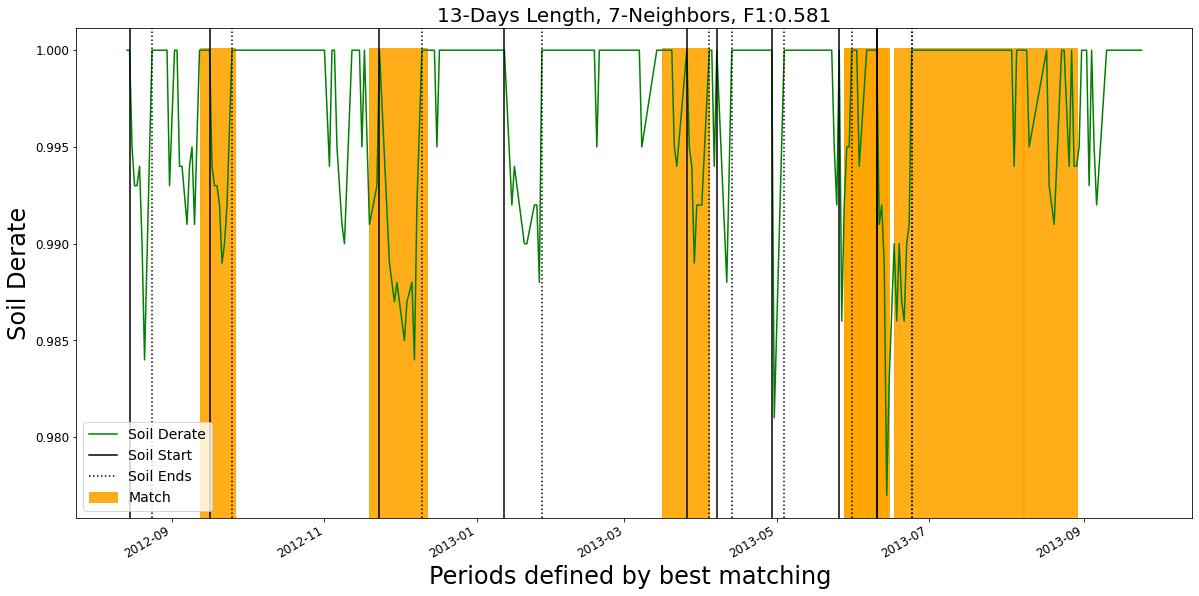

              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82       172
         1.0       0.55      0.61      0.58        70

    accuracy                           0.74       242
   macro avg       0.69      0.71      0.70       242
weighted avg       0.75      0.74      0.75       242



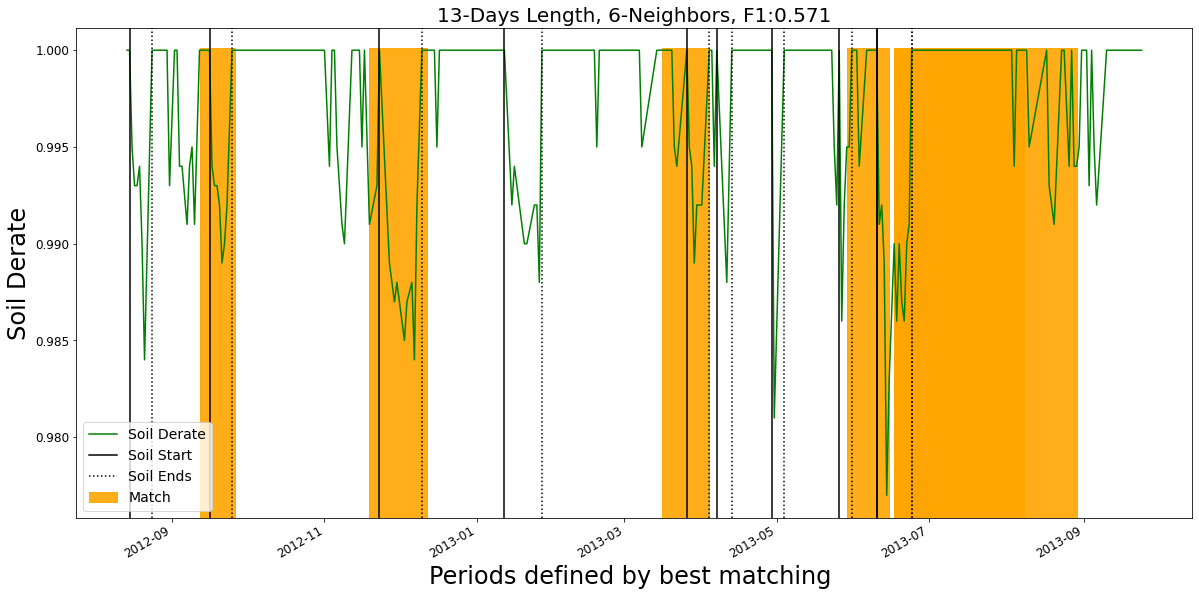

              precision    recall  f1-score   support

         0.0       0.83      0.80      0.81       172
         1.0       0.55      0.60      0.57        70

    accuracy                           0.74       242
   macro avg       0.69      0.70      0.69       242
weighted avg       0.75      0.74      0.74       242

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
2/2
cocoa.csv
We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (331, 7)
We found 2 Soiling Events with decay less than 0.989 


  0%|          | 0/569 [00:00<?, ?it/s]

  0%|          | 1/569 [00:00<02:23,  3.97it/s]

  0%|          | 2/569 [00:01<09:14,  1.02it/s]

  1%|          | 3/569 [00:02<06:50,  1.38it/s]

  1%|          | 4/569 [00:02<04:42,  2.00it/s]

  1%|          | 5/569 [00:03<05:59,  1.57it/s]

  1%|          | 7/569 [00:04<05:23,  1.74it/s]

  1%|▏         | 8/569 [00:05<06:21,  1.47it/s]

  2%|▏         | 9/569 [00:05<05:18,  1.76it/s]

  2%|▏         | 10/569 [00:05<05:08,  1.81it/s]

  2%|▏         | 11/569 [00:06<05:06,  1.82it/s]

  2%|▏         | 12/569 [00:06<03:58,  2.34it/s]

  2%|▏         | 13/569 [00:07<04:25,  2.09it/s]

  2%|▏         | 14/569 [00:08<05:10,  1.79it/s]

  3%|▎         | 15/569 [00:08<04:27,  2.07it/s]

  3%|▎         | 16/569 [00:08<03:54,  2.36it/s]

  3%|▎         | 17/569 [00:09<04:11,  2.20it/s]

  3%|▎         | 18/569 [00:09<03:34,  2.57it/s]

  3%|▎         | 19/569 [00:09<03:30,  2.61it/s]

  4%|▎         | 20/569 [00:10<04:21,  2.10it/s]

  4%|▎         | 21/569 [00:12<07:31,  1.21it/s]

  4%|▍         | 22/569 [00:12<07:38,  1.19it/s]

  4%|▍         | 23/569 [00:13<06:05,  1.49it/s]

  4%|▍         | 24/569 [00:13<05:01,  1.81it/s]

  4%|▍         | 25/569 [00:13<04:53,  1.86it/s]

  5%|▍         | 26/569 [00:15<06:45,  1.34it/s]

  5%|▍         | 27/569 [00:15<06:05,  1.48it/s]

  5%|▍         | 28/569 [00:16<06:56,  1.30it/s]

  5%|▌         | 29/569 [00:17<06:05,  1.48it/s]

  5%|▌         | 30/569 [00:17<04:54,  1.83it/s]

  5%|▌         | 31/569 [00:18<06:18,  1.42it/s]

  6%|▌         | 32/569 [00:19<08:09,  1.10it/s]

  6%|▌         | 33/569 [00:20<06:05,  1.47it/s]

  6%|▌         | 34/569 [00:20<05:25,  1.64it/s]

  6%|▌         | 35/569 [00:21<07:37,  1.17it/s]

  6%|▋         | 36/569 [00:22<05:51,  1.52it/s]

  7%|▋         | 37/569 [00:23<07:08,  1.24it/s]

  7%|▋         | 38/569 [00:23<06:22,  1.39it/s]

  7%|▋         | 39/569 [00:24<05:55,  1.49it/s]

  7%|▋         | 40/569 [00:24<05:27,  1.62it/s]

  7%|▋         | 41/569 [00:25<05:48,  1.52it/s]

  7%|▋         | 42/569 [00:26<06:05,  1.44it/s]

  8%|▊         | 43/569 [00:26<05:08,  1.70it/s]

  8%|▊         | 44/569 [00:27<04:31,  1.93it/s]

  8%|▊         | 45/569 [00:27<04:20,  2.01it/s]

  8%|▊         | 46/569 [00:27<04:15,  2.05it/s]

  8%|▊         | 47/569 [00:28<04:16,  2.03it/s]

  8%|▊         | 48/569 [00:29<05:13,  1.66it/s]

  9%|▊         | 49/569 [00:30<05:25,  1.60it/s]

  9%|▉         | 50/569 [00:30<05:38,  1.53it/s]

  9%|▉         | 51/569 [00:31<06:07,  1.41it/s]

  9%|▉         | 52/569 [00:32<06:13,  1.39it/s]

  9%|▉         | 53/569 [00:32<04:55,  1.75it/s]

  9%|▉         | 54/569 [00:33<04:39,  1.84it/s]

 10%|▉         | 55/569 [00:34<06:26,  1.33it/s]

 10%|▉         | 56/569 [00:34<06:03,  1.41it/s]

 10%|█         | 57/569 [00:35<06:55,  1.23it/s]

 10%|█         | 58/569 [00:37<08:58,  1.05s/it]

 10%|█         | 59/569 [00:38<08:20,  1.02it/s]

 11%|█         | 60/569 [00:39<09:20,  1.10s/it]

 11%|█         | 61/569 [00:40<09:36,  1.14s/it]

 11%|█         | 62/569 [00:41<08:41,  1.03s/it]

 11%|█         | 63/569 [00:42<08:11,  1.03it/s]

 11%|█         | 64/569 [00:43<07:12,  1.17it/s]

 11%|█▏        | 65/569 [00:44<08:39,  1.03s/it]

 12%|█▏        | 66/569 [00:45<09:35,  1.14s/it]

 12%|█▏        | 67/569 [00:47<11:06,  1.33s/it]

 12%|█▏        | 68/569 [00:51<17:11,  2.06s/it]

 12%|█▏        | 69/569 [00:54<18:36,  2.23s/it]

 12%|█▏        | 70/569 [00:56<18:12,  2.19s/it]

 12%|█▏        | 71/569 [01:07<40:38,  4.90s/it]

 13%|█▎        | 72/569 [01:18<55:52,  6.75s/it]

 13%|█▎        | 73/569 [01:23<51:56,  6.28s/it]

 13%|█▎        | 74/569 [01:26<42:39,  5.17s/it]

 13%|█▎        | 75/569 [01:27<33:59,  4.13s/it]

 13%|█▎        | 76/569 [01:29<28:18,  3.44s/it]

 14%|█▎        | 77/569 [01:30<21:10,  2.58s/it]

 14%|█▎        | 78/569 [01:32<19:04,  2.33s/it]

 14%|█▍        | 79/569 [01:32<13:56,  1.71s/it]

 14%|█▍        | 80/569 [01:33<11:54,  1.46s/it]

 14%|█▍        | 81/569 [01:34<11:31,  1.42s/it]

 14%|█▍        | 82/569 [01:35<09:29,  1.17s/it]

 15%|█▍        | 83/569 [01:35<08:06,  1.00s/it]

 15%|█▍        | 84/569 [01:36<06:53,  1.17it/s]

 15%|█▍        | 85/569 [01:36<06:14,  1.29it/s]

 15%|█▌        | 86/569 [01:37<06:31,  1.23it/s]

 15%|█▌        | 87/569 [01:38<06:17,  1.28it/s]

 15%|█▌        | 88/569 [01:38<05:16,  1.52it/s]

 16%|█▌        | 89/569 [01:39<04:24,  1.82it/s]

 16%|█▌        | 90/569 [01:39<04:48,  1.66it/s]

 16%|█▌        | 91/569 [01:40<05:03,  1.57it/s]

 16%|█▌        | 92/569 [01:42<07:10,  1.11it/s]

 16%|█▋        | 93/569 [01:42<06:32,  1.21it/s]

 17%|█▋        | 94/569 [01:43<05:14,  1.51it/s]

 17%|█▋        | 95/569 [01:43<05:02,  1.57it/s]

 17%|█▋        | 96/569 [01:44<05:09,  1.53it/s]

 17%|█▋        | 97/569 [01:44<04:36,  1.71it/s]

 17%|█▋        | 98/569 [01:45<04:29,  1.75it/s]

 17%|█▋        | 99/569 [01:45<03:44,  2.09it/s]

 18%|█▊        | 100/569 [01:45<03:14,  2.41it/s]

 18%|█▊        | 101/569 [01:46<04:11,  1.86it/s]

 18%|█▊        | 102/569 [01:46<03:29,  2.23it/s]

 18%|█▊        | 103/569 [01:47<02:45,  2.82it/s]

 18%|█▊        | 104/569 [01:47<03:12,  2.42it/s]

 18%|█▊        | 105/569 [01:47<02:59,  2.59it/s]

 19%|█▊        | 106/569 [01:48<03:29,  2.22it/s]

 19%|█▉        | 107/569 [01:48<03:32,  2.18it/s]

 19%|█▉        | 108/569 [01:49<03:52,  1.98it/s]

 19%|█▉        | 109/569 [01:49<03:33,  2.16it/s]

 19%|█▉        | 110/569 [01:50<03:15,  2.35it/s]

 20%|█▉        | 111/569 [01:50<03:32,  2.15it/s]

 20%|█▉        | 112/569 [01:51<03:57,  1.93it/s]

 20%|█▉        | 113/569 [01:52<04:30,  1.69it/s]

 20%|██        | 114/569 [01:52<04:25,  1.71it/s]

 20%|██        | 115/569 [01:53<04:01,  1.88it/s]

 20%|██        | 116/569 [01:53<03:28,  2.18it/s]

 21%|██        | 117/569 [01:54<03:32,  2.12it/s]

 21%|██        | 118/569 [01:54<04:19,  1.74it/s]

 21%|██        | 119/569 [01:55<04:16,  1.75it/s]

 21%|██        | 120/569 [01:56<04:43,  1.58it/s]

 21%|██▏       | 121/569 [01:56<04:43,  1.58it/s]

 21%|██▏       | 122/569 [01:57<05:05,  1.46it/s]

 22%|██▏       | 123/569 [01:58<04:27,  1.67it/s]

 22%|██▏       | 124/569 [01:58<04:40,  1.58it/s]

 22%|██▏       | 125/569 [01:58<03:51,  1.92it/s]

 22%|██▏       | 126/569 [01:59<04:44,  1.56it/s]

 22%|██▏       | 127/569 [02:00<04:12,  1.75it/s]

 22%|██▏       | 128/569 [02:00<03:38,  2.02it/s]

 23%|██▎       | 129/569 [02:01<04:55,  1.49it/s]

 23%|██▎       | 130/569 [02:02<04:43,  1.55it/s]

 23%|██▎       | 131/569 [02:02<04:31,  1.61it/s]

 23%|██▎       | 132/569 [02:03<03:43,  1.95it/s]

 23%|██▎       | 133/569 [02:03<04:12,  1.73it/s]

 24%|██▎       | 134/569 [02:04<04:01,  1.80it/s]

 24%|██▎       | 135/569 [02:04<04:11,  1.73it/s]

 24%|██▍       | 136/569 [02:05<04:12,  1.71it/s]

 24%|██▍       | 137/569 [02:06<04:12,  1.71it/s]

 24%|██▍       | 138/569 [02:06<04:22,  1.64it/s]

 24%|██▍       | 139/569 [02:07<03:57,  1.81it/s]

 25%|██▍       | 140/569 [02:07<03:11,  2.24it/s]

 25%|██▍       | 141/569 [02:08<03:43,  1.91it/s]

 25%|██▍       | 142/569 [02:08<03:51,  1.84it/s]

 25%|██▌       | 143/569 [02:09<03:32,  2.00it/s]

 25%|██▌       | 144/569 [02:09<03:11,  2.21it/s]

 25%|██▌       | 145/569 [02:09<03:07,  2.27it/s]

 26%|██▌       | 146/569 [02:10<03:48,  1.86it/s]

 26%|██▌       | 147/569 [02:12<06:01,  1.17it/s]

 26%|██▌       | 148/569 [02:13<05:47,  1.21it/s]

 26%|██▌       | 149/569 [02:13<04:49,  1.45it/s]

 26%|██▋       | 150/569 [02:13<04:03,  1.72it/s]

 27%|██▋       | 151/569 [02:14<04:10,  1.67it/s]

 27%|██▋       | 152/569 [02:15<04:23,  1.58it/s]

 27%|██▋       | 153/569 [02:15<04:03,  1.71it/s]

 27%|██▋       | 154/569 [02:15<03:14,  2.14it/s]

 27%|██▋       | 155/569 [02:16<03:07,  2.21it/s]

 27%|██▋       | 156/569 [02:16<03:03,  2.25it/s]

 28%|██▊       | 157/569 [02:17<03:06,  2.21it/s]

 28%|██▊       | 158/569 [02:17<02:55,  2.34it/s]

 28%|██▊       | 159/569 [02:17<02:57,  2.31it/s]

 28%|██▊       | 160/569 [02:18<03:30,  1.95it/s]

 28%|██▊       | 161/569 [02:19<03:28,  1.96it/s]

 28%|██▊       | 162/569 [02:19<03:23,  2.00it/s]

 29%|██▊       | 163/569 [02:20<03:36,  1.87it/s]

 29%|██▉       | 164/569 [02:20<03:54,  1.73it/s]

 29%|██▉       | 165/569 [02:21<05:00,  1.35it/s]

 29%|██▉       | 166/569 [02:22<04:56,  1.36it/s]

 29%|██▉       | 167/569 [02:23<04:08,  1.62it/s]

 30%|██▉       | 168/569 [02:23<04:00,  1.67it/s]

 30%|██▉       | 169/569 [02:23<03:16,  2.04it/s]

 30%|██▉       | 170/569 [02:24<03:45,  1.77it/s]

 30%|███       | 171/569 [02:25<03:40,  1.81it/s]

 30%|███       | 172/569 [02:25<04:00,  1.65it/s]

 30%|███       | 173/569 [02:26<03:27,  1.91it/s]

 31%|███       | 174/569 [02:26<03:45,  1.75it/s]

 31%|███       | 175/569 [02:27<03:04,  2.13it/s]

 31%|███       | 176/569 [02:27<03:19,  1.97it/s]

 31%|███       | 177/569 [02:28<03:35,  1.82it/s]

 31%|███▏      | 178/569 [02:28<03:18,  1.97it/s]

 31%|███▏      | 179/569 [02:29<02:59,  2.17it/s]

 32%|███▏      | 180/569 [02:29<02:45,  2.35it/s]

 32%|███▏      | 181/569 [02:30<03:29,  1.85it/s]

 32%|███▏      | 182/569 [02:30<03:36,  1.79it/s]

 32%|███▏      | 183/569 [02:31<04:43,  1.36it/s]

 32%|███▏      | 184/569 [02:32<04:21,  1.47it/s]

 33%|███▎      | 185/569 [02:33<04:07,  1.55it/s]

 33%|███▎      | 186/569 [02:33<03:48,  1.68it/s]

 33%|███▎      | 187/569 [02:34<03:40,  1.73it/s]

 33%|███▎      | 188/569 [02:34<04:04,  1.56it/s]

 33%|███▎      | 189/569 [02:35<04:03,  1.56it/s]

 33%|███▎      | 190/569 [02:35<03:38,  1.74it/s]

 34%|███▎      | 191/569 [02:36<03:48,  1.65it/s]

 34%|███▎      | 192/569 [02:36<03:20,  1.88it/s]

 34%|███▍      | 193/569 [02:37<03:46,  1.66it/s]

 34%|███▍      | 194/569 [02:38<03:56,  1.59it/s]

 34%|███▍      | 195/569 [02:38<03:21,  1.86it/s]

 34%|███▍      | 196/569 [02:39<03:27,  1.80it/s]

 35%|███▍      | 197/569 [02:39<03:14,  1.91it/s]

 35%|███▍      | 198/569 [02:40<03:36,  1.71it/s]

 35%|███▍      | 199/569 [02:41<04:50,  1.28it/s]

 35%|███▌      | 200/569 [02:42<05:25,  1.14it/s]

 35%|███▌      | 201/569 [02:43<05:15,  1.17it/s]

 36%|███▌      | 202/569 [02:44<05:08,  1.19it/s]

 36%|███▌      | 203/569 [02:45<05:31,  1.10it/s]

 36%|███▌      | 204/569 [02:46<06:10,  1.02s/it]

 36%|███▌      | 205/569 [02:47<05:49,  1.04it/s]

 36%|███▌      | 206/569 [02:48<05:13,  1.16it/s]

 36%|███▋      | 207/569 [02:49<05:49,  1.04it/s]

 37%|███▋      | 208/569 [02:50<06:04,  1.01s/it]

 37%|███▋      | 209/569 [02:52<06:46,  1.13s/it]

 37%|███▋      | 210/569 [02:52<04:59,  1.20it/s]

 37%|███▋      | 211/569 [02:52<04:42,  1.27it/s]

 37%|███▋      | 212/569 [02:53<04:32,  1.31it/s]

 37%|███▋      | 213/569 [02:54<04:04,  1.46it/s]

 38%|███▊      | 214/569 [02:54<03:30,  1.68it/s]

 38%|███▊      | 215/569 [02:55<03:33,  1.65it/s]

 38%|███▊      | 216/569 [02:57<05:59,  1.02s/it]

 38%|███▊      | 217/569 [02:58<06:46,  1.16s/it]

 38%|███▊      | 218/569 [02:59<06:55,  1.18s/it]

 38%|███▊      | 219/569 [03:03<10:58,  1.88s/it]

 39%|███▊      | 220/569 [03:06<12:44,  2.19s/it]

 39%|███▉      | 221/569 [03:08<13:35,  2.34s/it]

 39%|███▉      | 222/569 [03:17<24:38,  4.26s/it]

 39%|███▉      | 223/569 [03:26<31:50,  5.52s/it]

 39%|███▉      | 224/569 [03:34<37:16,  6.48s/it]

 40%|███▉      | 225/569 [03:37<30:07,  5.25s/it]

 40%|███▉      | 226/569 [03:39<24:53,  4.35s/it]

 40%|███▉      | 227/569 [03:42<23:18,  4.09s/it]

 40%|████      | 228/569 [03:43<17:30,  3.08s/it]

 40%|████      | 229/569 [03:44<13:32,  2.39s/it]

 40%|████      | 230/569 [03:45<11:52,  2.10s/it]

 41%|████      | 231/569 [03:46<09:16,  1.65s/it]

 41%|████      | 232/569 [03:48<09:07,  1.63s/it]

 41%|████      | 233/569 [03:49<09:21,  1.67s/it]

 41%|████      | 234/569 [03:50<07:48,  1.40s/it]

 41%|████▏     | 235/569 [03:51<07:33,  1.36s/it]

 41%|████▏     | 236/569 [03:52<06:27,  1.16s/it]

 42%|████▏     | 237/569 [03:53<05:39,  1.02s/it]

 42%|████▏     | 238/569 [03:53<05:06,  1.08it/s]

 42%|████▏     | 239/569 [03:54<04:55,  1.12it/s]

 42%|████▏     | 240/569 [03:55<04:52,  1.13it/s]

 42%|████▏     | 241/569 [03:56<04:27,  1.23it/s]

 43%|████▎     | 242/569 [03:56<03:47,  1.43it/s]

 43%|████▎     | 243/569 [03:56<02:56,  1.85it/s]

 43%|████▎     | 244/569 [03:57<02:28,  2.18it/s]

 43%|████▎     | 245/569 [03:57<02:13,  2.43it/s]

 43%|████▎     | 246/569 [03:58<02:42,  1.99it/s]

 43%|████▎     | 247/569 [03:58<03:04,  1.74it/s]

 44%|████▎     | 248/569 [03:59<03:06,  1.72it/s]

 44%|████▍     | 249/569 [04:00<03:14,  1.64it/s]

 44%|████▍     | 250/569 [04:00<02:48,  1.89it/s]

 44%|████▍     | 251/569 [04:01<03:43,  1.42it/s]

 44%|████▍     | 252/569 [04:02<03:29,  1.51it/s]

 44%|████▍     | 253/569 [04:02<03:18,  1.59it/s]

 45%|████▍     | 254/569 [04:02<02:37,  2.00it/s]

 45%|████▍     | 255/569 [04:03<02:57,  1.77it/s]

 45%|████▍     | 256/569 [04:04<02:55,  1.78it/s]

 45%|████▌     | 257/569 [04:05<03:15,  1.59it/s]

 45%|████▌     | 258/569 [04:05<03:27,  1.50it/s]

 46%|████▌     | 259/569 [04:06<02:55,  1.77it/s]

 46%|████▌     | 260/569 [04:06<02:25,  2.12it/s]

 46%|████▌     | 261/569 [04:06<02:09,  2.37it/s]

 46%|████▌     | 262/569 [04:07<02:05,  2.45it/s]

 46%|████▌     | 263/569 [04:07<02:22,  2.15it/s]

 46%|████▋     | 264/569 [04:08<02:37,  1.94it/s]

 47%|████▋     | 265/569 [04:08<02:33,  1.98it/s]

 47%|████▋     | 266/569 [04:09<02:12,  2.28it/s]

 47%|████▋     | 267/569 [04:09<02:28,  2.04it/s]

 47%|████▋     | 268/569 [04:10<03:00,  1.67it/s]

 47%|████▋     | 269/569 [04:12<04:23,  1.14it/s]

 47%|████▋     | 270/569 [04:12<04:11,  1.19it/s]

 48%|████▊     | 271/569 [04:13<03:54,  1.27it/s]

 48%|████▊     | 272/569 [04:13<03:33,  1.39it/s]

 48%|████▊     | 273/569 [04:14<03:38,  1.36it/s]

 48%|████▊     | 274/569 [04:15<03:18,  1.49it/s]

 48%|████▊     | 275/569 [04:15<03:00,  1.63it/s]

 49%|████▊     | 276/569 [04:16<03:00,  1.62it/s]

 49%|████▊     | 277/569 [04:17<03:15,  1.49it/s]

 49%|████▉     | 278/569 [04:17<02:53,  1.67it/s]

 49%|████▉     | 279/569 [04:18<03:04,  1.58it/s]

 49%|████▉     | 280/569 [04:18<02:43,  1.77it/s]

 49%|████▉     | 281/569 [04:19<02:33,  1.88it/s]

 50%|████▉     | 282/569 [04:19<02:41,  1.78it/s]

 50%|████▉     | 283/569 [04:20<02:11,  2.17it/s]

 50%|████▉     | 284/569 [04:20<02:06,  2.26it/s]

 50%|█████     | 285/569 [04:21<03:29,  1.35it/s]

 50%|█████     | 286/569 [04:22<03:31,  1.34it/s]

 50%|█████     | 287/569 [04:22<02:45,  1.70it/s]

 51%|█████     | 288/569 [04:23<02:32,  1.84it/s]

 51%|█████     | 289/569 [04:23<02:15,  2.07it/s]

 51%|█████     | 290/569 [04:24<02:13,  2.09it/s]

 51%|█████     | 291/569 [04:24<01:59,  2.32it/s]

 51%|█████▏    | 292/569 [04:24<01:47,  2.57it/s]

 51%|█████▏    | 293/569 [04:25<01:46,  2.60it/s]

 52%|█████▏    | 294/569 [04:25<02:00,  2.28it/s]

 52%|█████▏    | 295/569 [04:26<02:40,  1.71it/s]

 52%|█████▏    | 296/569 [04:27<02:48,  1.62it/s]

 52%|█████▏    | 297/569 [04:27<02:25,  1.87it/s]

 52%|█████▏    | 298/569 [04:28<02:33,  1.76it/s]

 53%|█████▎    | 299/569 [04:28<02:28,  1.82it/s]

 53%|█████▎    | 300/569 [04:29<02:32,  1.76it/s]

 53%|█████▎    | 301/569 [04:29<02:35,  1.73it/s]

 53%|█████▎    | 302/569 [04:30<02:28,  1.80it/s]

 53%|█████▎    | 303/569 [04:31<03:24,  1.30it/s]

 53%|█████▎    | 304/569 [04:31<02:35,  1.71it/s]

 54%|█████▎    | 305/569 [04:32<02:26,  1.80it/s]

 54%|█████▍    | 306/569 [04:33<02:36,  1.68it/s]

 54%|█████▍    | 307/569 [04:33<02:59,  1.46it/s]

 54%|█████▍    | 308/569 [04:34<02:42,  1.61it/s]

 54%|█████▍    | 309/569 [04:34<02:16,  1.91it/s]

 54%|█████▍    | 310/569 [04:35<02:13,  1.95it/s]

 55%|█████▍    | 311/569 [04:35<02:24,  1.79it/s]

 55%|█████▍    | 312/569 [04:36<02:37,  1.63it/s]

 55%|█████▌    | 313/569 [04:37<02:31,  1.69it/s]

 55%|█████▌    | 314/569 [04:38<02:48,  1.51it/s]

 55%|█████▌    | 315/569 [04:38<02:43,  1.55it/s]

 56%|█████▌    | 316/569 [04:39<02:38,  1.59it/s]

 56%|█████▌    | 317/569 [04:39<02:34,  1.64it/s]

 56%|█████▌    | 318/569 [04:40<02:17,  1.83it/s]

 56%|█████▌    | 319/569 [04:40<02:19,  1.79it/s]

 56%|█████▌    | 320/569 [04:42<03:10,  1.31it/s]

 56%|█████▋    | 321/569 [04:42<03:09,  1.31it/s]

 57%|█████▋    | 322/569 [04:43<02:32,  1.62it/s]

 57%|█████▋    | 323/569 [04:43<02:30,  1.63it/s]

 57%|█████▋    | 324/569 [04:44<02:34,  1.59it/s]

 57%|█████▋    | 325/569 [04:44<02:36,  1.56it/s]

 57%|█████▋    | 326/569 [04:45<02:30,  1.61it/s]

 57%|█████▋    | 327/569 [04:45<02:15,  1.78it/s]

 58%|█████▊    | 328/569 [04:46<01:55,  2.09it/s]

 58%|█████▊    | 329/569 [04:46<02:04,  1.92it/s]

 58%|█████▊    | 330/569 [04:47<02:04,  1.92it/s]

 58%|█████▊    | 331/569 [04:48<02:18,  1.72it/s]

 58%|█████▊    | 332/569 [04:48<02:18,  1.72it/s]

 59%|█████▊    | 333/569 [04:49<02:13,  1.76it/s]

 59%|█████▊    | 334/569 [04:49<02:16,  1.72it/s]

 59%|█████▉    | 335/569 [04:50<01:51,  2.10it/s]

 59%|█████▉    | 336/569 [04:50<01:52,  2.06it/s]

 59%|█████▉    | 337/569 [04:51<02:19,  1.66it/s]

 59%|█████▉    | 338/569 [04:52<02:55,  1.32it/s]

 60%|█████▉    | 339/569 [04:53<03:08,  1.22it/s]

 60%|█████▉    | 340/569 [04:54<03:28,  1.10it/s]

 60%|█████▉    | 341/569 [04:56<04:55,  1.30s/it]

 60%|██████    | 342/569 [04:57<03:52,  1.02s/it]

 60%|██████    | 343/569 [04:58<03:52,  1.03s/it]

 60%|██████    | 344/569 [04:59<03:36,  1.04it/s]

 61%|██████    | 345/569 [04:59<03:21,  1.11it/s]

 61%|██████    | 346/569 [05:02<04:43,  1.27s/it]

 61%|██████    | 347/569 [05:02<03:51,  1.04s/it]

 61%|██████    | 348/569 [05:03<03:32,  1.04it/s]

 61%|██████▏   | 349/569 [05:03<02:49,  1.30it/s]

 62%|██████▏   | 350/569 [05:04<02:26,  1.49it/s]

 62%|██████▏   | 351/569 [05:04<02:34,  1.41it/s]

 62%|██████▏   | 352/569 [05:05<02:27,  1.47it/s]

 62%|██████▏   | 353/569 [05:06<03:08,  1.15it/s]

 62%|██████▏   | 354/569 [05:08<04:06,  1.15s/it]

 62%|██████▏   | 355/569 [05:10<04:48,  1.35s/it]

 63%|██████▎   | 356/569 [05:11<04:45,  1.34s/it]

 63%|██████▎   | 357/569 [05:13<05:06,  1.44s/it]

 63%|██████▎   | 358/569 [05:16<06:27,  1.83s/it]

 63%|██████▎   | 359/569 [05:25<14:42,  4.20s/it]

 63%|██████▎   | 360/569 [05:36<21:39,  6.22s/it]

 63%|██████▎   | 361/569 [05:47<25:47,  7.44s/it]

 64%|██████▎   | 362/569 [05:49<20:46,  6.02s/it]

 64%|██████▍   | 363/569 [05:52<17:17,  5.04s/it]

 64%|██████▍   | 364/569 [05:53<13:07,  3.84s/it]

 64%|██████▍   | 365/569 [05:54<10:26,  3.07s/it]

 64%|██████▍   | 366/569 [05:55<07:38,  2.26s/it]

 64%|██████▍   | 367/569 [05:56<06:41,  1.99s/it]

 65%|██████▍   | 368/569 [05:57<05:54,  1.77s/it]

 65%|██████▍   | 369/569 [05:59<05:38,  1.69s/it]

 65%|██████▌   | 370/569 [06:00<04:54,  1.48s/it]

 65%|██████▌   | 371/569 [06:01<05:00,  1.52s/it]

 65%|██████▌   | 372/569 [06:02<04:07,  1.26s/it]

 66%|██████▌   | 373/569 [06:03<03:26,  1.05s/it]

 66%|██████▌   | 374/569 [06:03<03:08,  1.03it/s]

 66%|██████▌   | 375/569 [06:04<03:02,  1.06it/s]

 66%|██████▌   | 376/569 [06:05<02:54,  1.10it/s]

 66%|██████▋   | 377/569 [06:06<02:25,  1.32it/s]

 66%|██████▋   | 378/569 [06:06<02:05,  1.52it/s]

 67%|██████▋   | 379/569 [06:06<01:43,  1.83it/s]

 67%|██████▋   | 380/569 [06:07<01:38,  1.92it/s]

 67%|██████▋   | 381/569 [06:07<01:17,  2.44it/s]

 67%|██████▋   | 382/569 [06:07<01:05,  2.84it/s]

 67%|██████▋   | 383/569 [06:07<01:03,  2.92it/s]

 67%|██████▋   | 384/569 [06:08<00:57,  3.21it/s]

 68%|██████▊   | 385/569 [06:08<00:55,  3.33it/s]

 68%|██████▊   | 386/569 [06:08<00:55,  3.29it/s]

 68%|██████▊   | 387/569 [06:09<01:26,  2.10it/s]

 68%|██████▊   | 388/569 [06:10<01:36,  1.87it/s]

 68%|██████▊   | 389/569 [06:10<01:30,  1.99it/s]

 69%|██████▊   | 390/569 [06:11<01:52,  1.59it/s]

 69%|██████▊   | 391/569 [06:12<01:54,  1.56it/s]

 69%|██████▉   | 392/569 [06:12<01:43,  1.72it/s]

 69%|██████▉   | 393/569 [06:13<01:34,  1.87it/s]

 69%|██████▉   | 394/569 [06:13<01:18,  2.24it/s]

 69%|██████▉   | 395/569 [06:14<01:35,  1.82it/s]

 70%|██████▉   | 396/569 [06:14<01:26,  2.01it/s]

 70%|██████▉   | 397/569 [06:15<01:23,  2.07it/s]

 70%|██████▉   | 398/569 [06:15<01:21,  2.11it/s]

 70%|███████   | 399/569 [06:16<01:30,  1.87it/s]

 70%|███████   | 400/569 [06:16<01:39,  1.70it/s]

 70%|███████   | 401/569 [06:17<01:21,  2.07it/s]

 71%|███████   | 402/569 [06:17<01:21,  2.05it/s]

 71%|███████   | 403/569 [06:18<01:30,  1.84it/s]

 71%|███████   | 404/569 [06:18<01:33,  1.77it/s]

 71%|███████   | 405/569 [06:19<01:21,  2.02it/s]

 71%|███████▏  | 406/569 [06:19<01:06,  2.46it/s]

 72%|███████▏  | 407/569 [06:19<00:55,  2.92it/s]

 72%|███████▏  | 408/569 [06:20<01:23,  1.93it/s]

 72%|███████▏  | 409/569 [06:21<01:48,  1.47it/s]

 72%|███████▏  | 410/569 [06:22<01:47,  1.48it/s]

 72%|███████▏  | 411/569 [06:22<01:39,  1.59it/s]

 72%|███████▏  | 412/569 [06:23<01:36,  1.62it/s]

 73%|███████▎  | 413/569 [06:24<01:43,  1.51it/s]

 73%|███████▎  | 414/569 [06:24<01:26,  1.80it/s]

 73%|███████▎  | 415/569 [06:25<01:31,  1.68it/s]

 73%|███████▎  | 416/569 [06:25<01:20,  1.91it/s]

 73%|███████▎  | 417/569 [06:25<01:15,  2.02it/s]

 73%|███████▎  | 418/569 [06:26<01:11,  2.11it/s]

 74%|███████▎  | 419/569 [06:27<01:22,  1.82it/s]

 74%|███████▍  | 420/569 [06:27<01:25,  1.75it/s]

 74%|███████▍  | 421/569 [06:28<01:27,  1.70it/s]

 74%|███████▍  | 422/569 [06:28<01:25,  1.73it/s]

 74%|███████▍  | 423/569 [06:29<01:23,  1.75it/s]

 75%|███████▍  | 424/569 [06:29<01:12,  2.01it/s]

 75%|███████▍  | 425/569 [06:30<01:18,  1.83it/s]

 75%|███████▍  | 426/569 [06:31<01:59,  1.19it/s]

 75%|███████▌  | 427/569 [06:32<01:46,  1.34it/s]

 75%|███████▌  | 428/569 [06:33<01:44,  1.35it/s]

 75%|███████▌  | 429/569 [06:33<01:42,  1.37it/s]

 76%|███████▌  | 430/569 [06:34<01:22,  1.69it/s]

 76%|███████▌  | 431/569 [06:34<01:23,  1.66it/s]

 76%|███████▌  | 432/569 [06:35<01:11,  1.92it/s]

 76%|███████▌  | 433/569 [06:35<01:06,  2.04it/s]

 76%|███████▋  | 434/569 [06:36<01:11,  1.88it/s]

 76%|███████▋  | 435/569 [06:37<01:22,  1.61it/s]

 77%|███████▋  | 436/569 [06:37<01:08,  1.93it/s]

 77%|███████▋  | 437/569 [06:37<01:02,  2.10it/s]

 77%|███████▋  | 438/569 [06:38<01:05,  1.99it/s]

 77%|███████▋  | 439/569 [06:38<01:09,  1.87it/s]

 77%|███████▋  | 440/569 [06:39<01:02,  2.05it/s]

 78%|███████▊  | 441/569 [06:39<01:01,  2.08it/s]

 78%|███████▊  | 442/569 [06:40<01:03,  2.00it/s]

 78%|███████▊  | 443/569 [06:40<00:58,  2.17it/s]

 78%|███████▊  | 444/569 [06:41<01:18,  1.59it/s]

 78%|███████▊  | 445/569 [06:42<01:15,  1.64it/s]

 78%|███████▊  | 446/569 [06:42<01:09,  1.78it/s]

 79%|███████▊  | 447/569 [06:42<01:00,  2.03it/s]

 79%|███████▊  | 448/569 [06:43<01:00,  2.01it/s]

 79%|███████▉  | 449/569 [06:43<00:48,  2.45it/s]

 79%|███████▉  | 450/569 [06:44<00:56,  2.10it/s]

 79%|███████▉  | 451/569 [06:44<00:46,  2.55it/s]

 79%|███████▉  | 452/569 [06:44<00:46,  2.50it/s]

 80%|███████▉  | 453/569 [06:45<00:37,  3.13it/s]

 80%|███████▉  | 454/569 [06:45<00:41,  2.74it/s]

 80%|███████▉  | 455/569 [06:45<00:35,  3.21it/s]

 80%|████████  | 456/569 [06:46<00:38,  2.96it/s]

 80%|████████  | 457/569 [06:46<00:46,  2.43it/s]

 80%|████████  | 458/569 [06:47<00:45,  2.42it/s]

 81%|████████  | 459/569 [06:47<00:57,  1.91it/s]

 81%|████████  | 460/569 [06:48<01:07,  1.61it/s]

 81%|████████  | 461/569 [06:49<00:58,  1.85it/s]

 81%|████████  | 462/569 [06:49<00:51,  2.06it/s]

 81%|████████▏ | 463/569 [06:49<00:48,  2.18it/s]

 82%|████████▏ | 464/569 [06:50<00:53,  1.95it/s]

 82%|████████▏ | 465/569 [06:51<01:16,  1.36it/s]

 82%|████████▏ | 466/569 [06:52<01:04,  1.59it/s]

 82%|████████▏ | 467/569 [06:52<01:03,  1.60it/s]

 82%|████████▏ | 468/569 [06:53<01:00,  1.66it/s]

 82%|████████▏ | 469/569 [06:53<00:56,  1.78it/s]

 83%|████████▎ | 470/569 [06:54<00:56,  1.75it/s]

 83%|████████▎ | 471/569 [06:54<00:42,  2.30it/s]

 83%|████████▎ | 472/569 [06:54<00:38,  2.55it/s]

 83%|████████▎ | 473/569 [06:55<00:40,  2.36it/s]

 83%|████████▎ | 474/569 [06:56<00:50,  1.87it/s]

 83%|████████▎ | 475/569 [06:56<00:52,  1.80it/s]

 84%|████████▎ | 476/569 [06:57<00:46,  1.99it/s]

 84%|████████▍ | 477/569 [06:57<00:43,  2.09it/s]

 84%|████████▍ | 478/569 [06:58<00:46,  1.96it/s]

 84%|████████▍ | 479/569 [06:58<00:41,  2.19it/s]

 84%|████████▍ | 480/569 [06:58<00:35,  2.48it/s]

 85%|████████▍ | 481/569 [06:59<00:39,  2.23it/s]

 85%|████████▍ | 482/569 [06:59<00:34,  2.51it/s]

 85%|████████▍ | 483/569 [07:00<00:43,  1.98it/s]

 85%|████████▌ | 484/569 [07:00<00:36,  2.34it/s]

 85%|████████▌ | 485/569 [07:02<01:05,  1.27it/s]

 85%|████████▌ | 486/569 [07:12<05:12,  3.76s/it]

 86%|████████▌ | 487/569 [07:16<05:04,  3.71s/it]

 86%|████████▌ | 488/569 [07:16<03:41,  2.74s/it]

 86%|████████▌ | 489/569 [07:17<02:42,  2.03s/it]

 86%|████████▌ | 490/569 [07:25<05:07,  3.89s/it]

 86%|████████▋ | 491/569 [07:30<05:39,  4.35s/it]

 86%|████████▋ | 492/569 [07:39<07:03,  5.51s/it]

 87%|████████▋ | 493/569 [07:43<06:26,  5.08s/it]

 87%|████████▋ | 494/569 [07:54<08:39,  6.93s/it]

 87%|████████▋ | 495/569 [07:56<06:43,  5.45s/it]

 87%|████████▋ | 496/569 [08:06<08:12,  6.74s/it]

 87%|████████▋ | 497/569 [08:14<08:40,  7.24s/it]

 88%|████████▊ | 498/569 [08:18<07:24,  6.27s/it]

 88%|████████▊ | 499/569 [08:23<06:50,  5.87s/it]

 88%|████████▊ | 500/569 [08:31<07:31,  6.54s/it]

 88%|████████▊ | 501/569 [08:36<06:57,  6.14s/it]

 88%|████████▊ | 502/569 [08:47<08:26,  7.56s/it]

 88%|████████▊ | 503/569 [08:58<09:28,  8.62s/it]

 89%|████████▊ | 504/569 [09:04<08:30,  7.85s/it]

 89%|████████▉ | 505/569 [09:14<08:56,  8.38s/it]

 89%|████████▉ | 506/569 [09:19<07:36,  7.25s/it]

 89%|████████▉ | 507/569 [09:30<08:38,  8.36s/it]

 89%|████████▉ | 508/569 [09:32<06:37,  6.51s/it]

 89%|████████▉ | 509/569 [09:32<04:40,  4.67s/it]

 90%|████████▉ | 510/569 [09:32<03:17,  3.35s/it]

 90%|████████▉ | 511/569 [09:33<02:27,  2.54s/it]

 90%|████████▉ | 512/569 [09:37<02:46,  2.93s/it]

 90%|█████████ | 513/569 [09:37<02:04,  2.23s/it]

 90%|█████████ | 514/569 [09:38<01:38,  1.80s/it]

 91%|█████████ | 515/569 [09:39<01:12,  1.34s/it]

 91%|█████████ | 516/569 [09:39<00:56,  1.07s/it]

 91%|█████████ | 517/569 [09:40<00:53,  1.03s/it]

 91%|█████████ | 518/569 [09:42<01:03,  1.24s/it]

 91%|█████████ | 519/569 [09:42<00:52,  1.05s/it]

 91%|█████████▏| 520/569 [09:43<00:43,  1.12it/s]

 92%|█████████▏| 521/569 [09:44<00:42,  1.14it/s]

 92%|█████████▏| 522/569 [09:44<00:33,  1.41it/s]

 92%|█████████▏| 523/569 [09:44<00:27,  1.66it/s]

 92%|█████████▏| 524/569 [09:45<00:27,  1.65it/s]

 92%|█████████▏| 525/569 [09:46<00:28,  1.53it/s]

 92%|█████████▏| 526/569 [09:46<00:26,  1.64it/s]

 93%|█████████▎| 527/569 [09:47<00:30,  1.38it/s]

 93%|█████████▎| 528/569 [09:48<00:33,  1.22it/s]

 93%|█████████▎| 529/569 [09:49<00:30,  1.33it/s]

 93%|█████████▎| 530/569 [10:00<02:36,  4.01s/it]

 93%|█████████▎| 531/569 [10:09<03:28,  5.49s/it]

 93%|█████████▎| 532/569 [10:20<04:22,  7.10s/it]

 94%|█████████▎| 533/569 [10:31<05:00,  8.34s/it]

 94%|█████████▍| 534/569 [10:43<05:21,  9.17s/it]

 94%|█████████▍| 535/569 [10:52<05:19,  9.39s/it]

 94%|█████████▍| 536/569 [11:03<05:20,  9.70s/it]

 94%|█████████▍| 537/569 [11:08<04:26,  8.34s/it]

 95%|█████████▍| 538/569 [11:19<04:38,  8.98s/it]

 95%|█████████▍| 539/569 [11:24<03:57,  7.91s/it]

 95%|█████████▍| 540/569 [11:31<03:40,  7.61s/it]

 95%|█████████▌| 541/569 [11:37<03:22,  7.25s/it]

 95%|█████████▌| 542/569 [11:38<02:19,  5.17s/it]

 95%|█████████▌| 543/569 [11:49<03:01,  6.99s/it]

 96%|█████████▌| 544/569 [11:58<03:11,  7.65s/it]

 96%|█████████▌| 545/569 [12:08<03:22,  8.45s/it]

 96%|█████████▌| 546/569 [12:19<03:32,  9.24s/it]

 96%|█████████▌| 547/569 [12:29<03:23,  9.23s/it]

 96%|█████████▋| 548/569 [12:30<02:21,  6.76s/it]

 96%|█████████▋| 549/569 [12:40<02:34,  7.70s/it]

 97%|█████████▋| 550/569 [12:51<02:47,  8.81s/it]

 97%|█████████▋| 551/569 [13:01<02:46,  9.24s/it]

 97%|█████████▋| 552/569 [13:06<02:17,  8.06s/it]

 97%|█████████▋| 553/569 [13:08<01:36,  6.05s/it]

 97%|█████████▋| 554/569 [13:18<01:50,  7.38s/it]

 98%|█████████▊| 555/569 [13:30<01:59,  8.56s/it]

 98%|█████████▊| 556/569 [13:40<01:58,  9.14s/it]

 98%|█████████▊| 557/569 [13:45<01:33,  7.79s/it]

 98%|█████████▊| 558/569 [13:47<01:05,  5.99s/it]

 98%|█████████▊| 559/569 [13:55<01:07,  6.74s/it]

 98%|█████████▊| 560/569 [14:06<01:12,  8.10s/it]

 99%|█████████▊| 561/569 [14:17<01:10,  8.85s/it]

 99%|█████████▉| 562/569 [14:26<01:03,  9.06s/it]

 99%|█████████▉| 563/569 [14:31<00:47,  7.84s/it]

 99%|█████████▉| 564/569 [14:41<00:41,  8.27s/it]

 99%|█████████▉| 565/569 [14:47<00:30,  7.60s/it]

 99%|█████████▉| 566/569 [14:58<00:25,  8.55s/it]

100%|█████████▉| 567/569 [15:03<00:15,  7.74s/it]

100%|█████████▉| 568/569 [15:13<00:08,  8.26s/it]

100%|██████████| 569/569 [15:19<00:00,  7.65s/it]

100%|██████████| 569/569 [15:19<00:00,  1.62s/it]

   profile_wind  exclusion_zone  motif_index  motif_type  actual_nei  \
0            12             2.0           50          10           2   
1            14             4.0           18          12           2   
2            13             inf          164           4           2   
3            12             5.0           21           4           2   
4            14             2.0          164           5           2   
5            10             4.0           48          14           2   

   actual_motif   recall       f1  precision  hamming  jaccard    cohen  \
0            14  0.71429  0.66667    0.62500  0.04532  0.50000  0.64247   
1            12  0.66667  0.57143    0.50000  0.06344  0.40000  0.53792   
2            11  0.61905  0.55319    0.50000  0.06344  0.38235  0.51946   
3            14  0.57143  0.53333    0.50000  0.06344  0.36364  0.49946   
4             5  0.61905  0.53061    0.46429  0.06949  0.36111  0.49392   
5            14  0.47619  0.52632    0.58824 

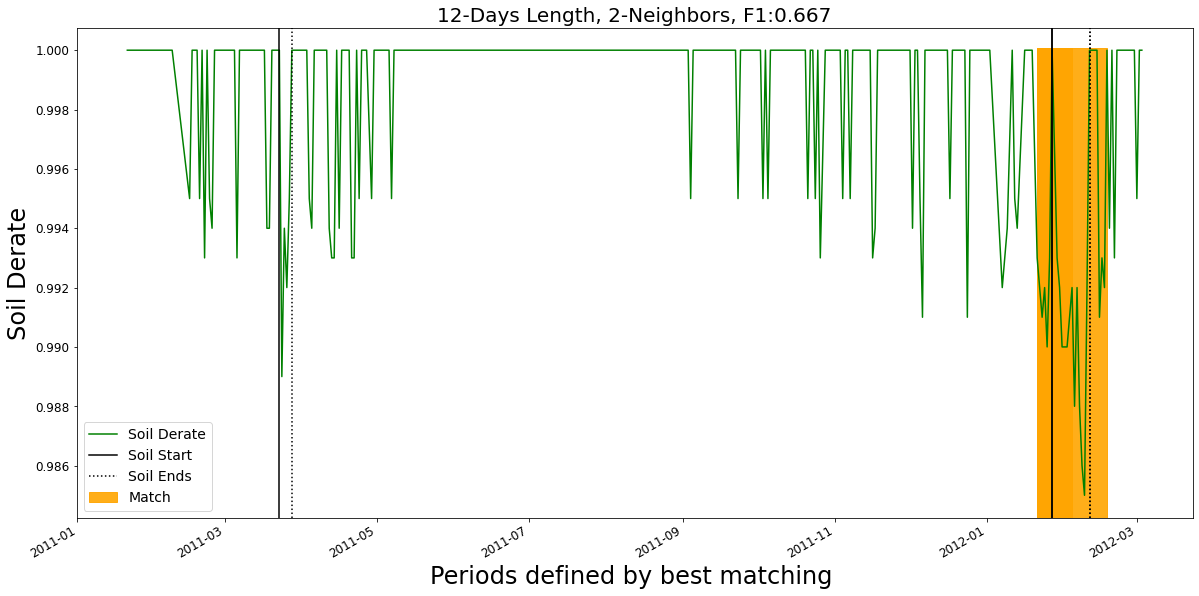

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       310
         1.0       0.62      0.71      0.67        21

    accuracy                           0.95       331
   macro avg       0.80      0.84      0.82       331
weighted avg       0.96      0.95      0.96       331



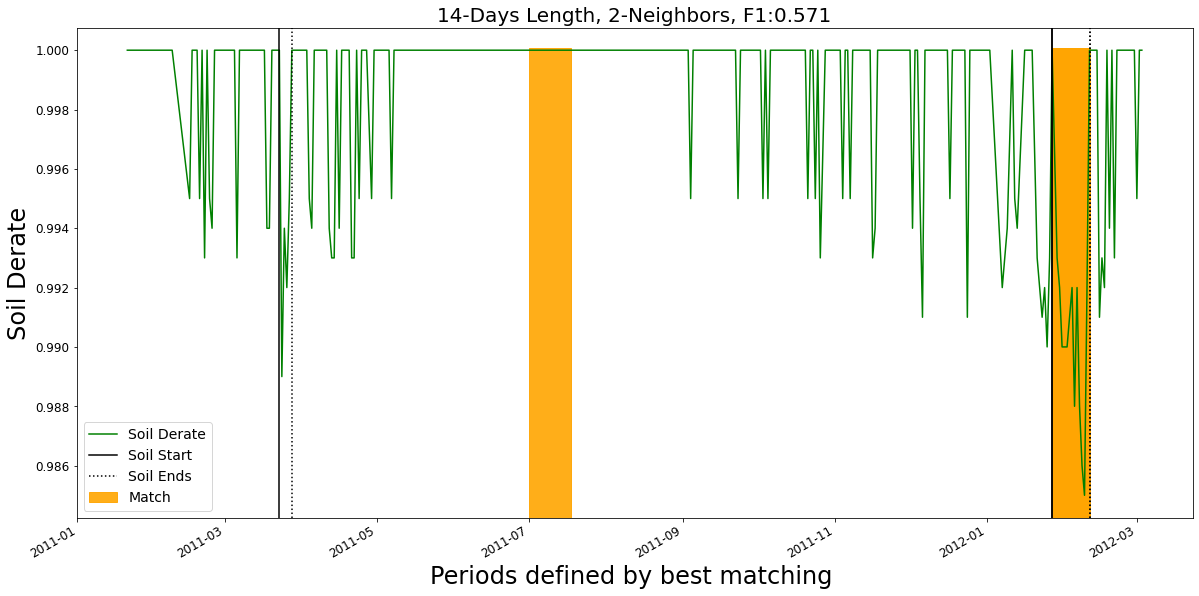

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97       310
         1.0       0.50      0.67      0.57        21

    accuracy                           0.94       331
   macro avg       0.74      0.81      0.77       331
weighted avg       0.95      0.94      0.94       331

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`


In [9]:
files=['golden.csv',
       'cocoa.csv']
count=1
for i,file in enumerate(files):
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")
    print(f'{count}/{len(files)}')
    print(file)
    count=count+1
    filename = file
    df=pd.read_csv(filename)
    df['timestamp']=pd.to_datetime(df['timestamp'])
    df=df.set_index('timestamp')
    #testing step
    if file=='golden.csv':
      # df=df.loc[:'2013-06-24']

      df.soiling_derate[0]=1
      df.soiling_derate[1]=1

    df.soiling_derate[-1]=1
    ##testing step
    print('We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event')
    print(f'Shape of our Timeseries: {df.shape}')
    df_soil_output=soiling_dates(df,y=x,plot=False)
#     print(f'Here we observe the exact dates which a soiling interval starts and stops')
#     print(df_soil_output)
    events=len(df_soil_output)
    df_new=df
    out,df_last=matching_eval(col,df_old,df_new,alles_df=end_df[end_df.f1>0.3],
                              events=len(df_soil_output),df_soil_output=df_soil_output,
                              n=len(end_df[end_df.f1>0.3]),plot=False)
    # df_last.to_csv(f'/home/pgidarakos/Genetic/Eugene/indirect_eval_{i}_deliv.csv',columns=df_last.columns,index=False)
    print(df_last.head(6))
    match_graph_multi_dim_eval(col,df_new,df_old,df_soil_output=df_soil_output,alles_df=df_last,n=2,plot=True)

    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")

### MP based pattern discovery 


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
golden.csv
1/2


We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (207, 7)
We found 9 Soiling Events with decay less than 0.989 


   min_nei  max_d  cutoff  max_m  max_motif  profile_wind  exclusion_zone  \
0        2   3.13    2.46      8         13            13             6.0   
1        0   3.36    2.68      8         11            13             5.0   
2        1   2.72    1.85     10         14            10             4.0   
3        1   3.63    1.41      9         14             8             2.0   
4        1   2.70    2.87      8         12            13             5.0   

         f1   jaccard    recall   hamming      pres  motif_type  
0  0.545455  0.375000  0.589286  0.265700  0.507692           6  
1  0.519685  0.351064  0.589286  0.294686  0.464789           7  
2  0.508772  0.341176  0.517857  0.270531  0.500000           8  
3  0.507937  0.340426  0.571429  0.299517  0.457143           6  
4  0.505263  0.338028  0.428571  0.227053  0.615385           7  


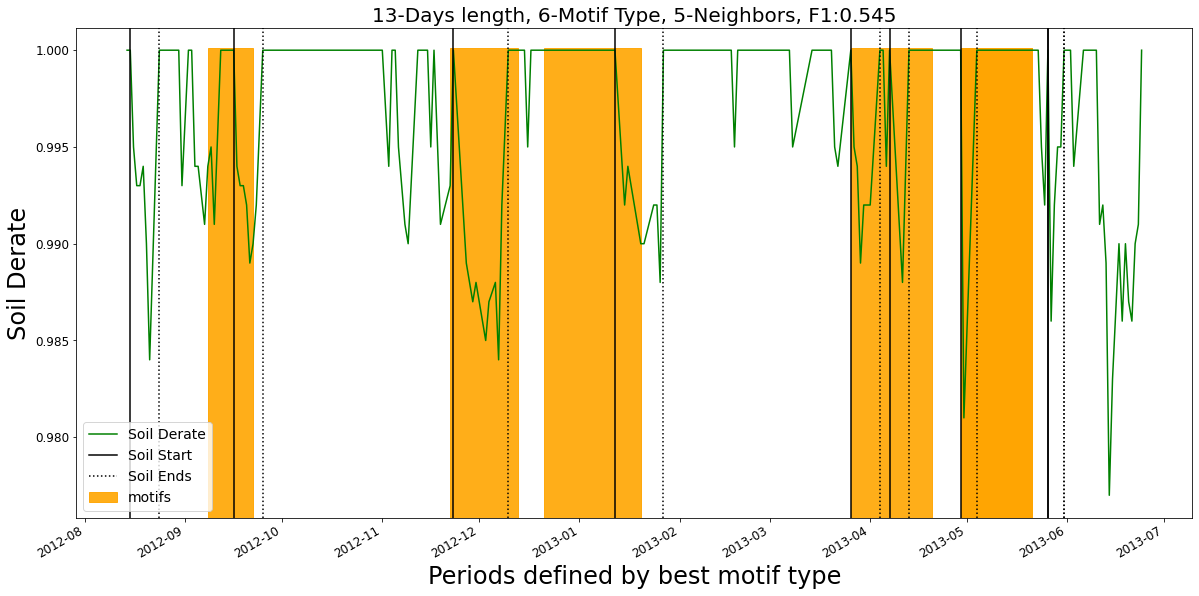

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.81       151
         1.0       0.51      0.59      0.55        56

    accuracy                           0.73       207
   macro avg       0.67      0.69      0.68       207
weighted avg       0.75      0.73      0.74       207



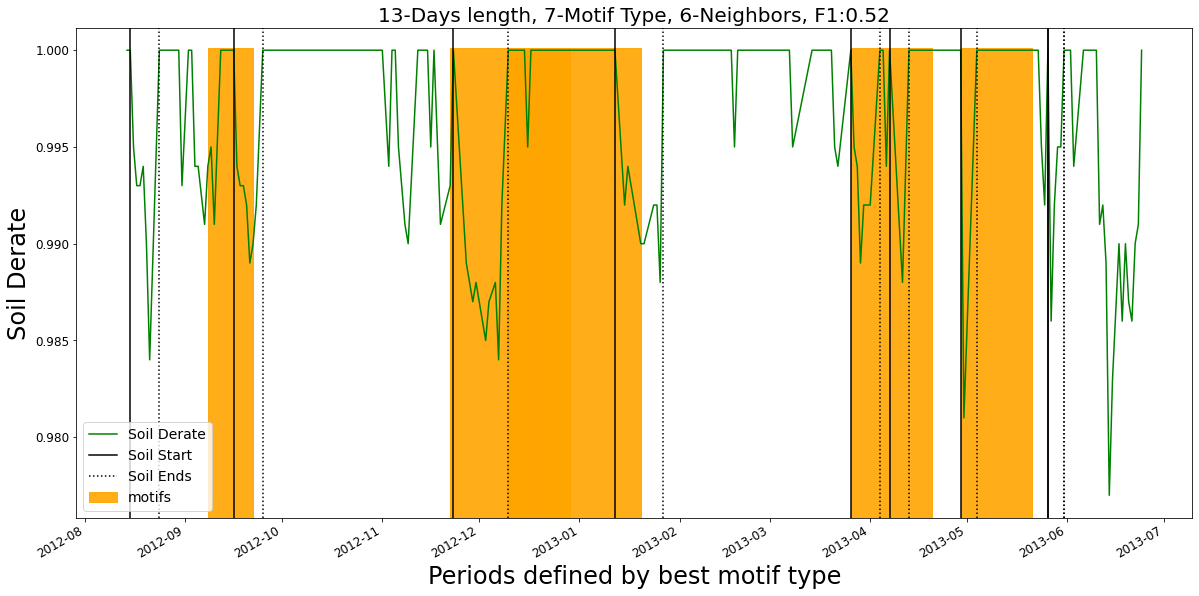

              precision    recall  f1-score   support

         0.0       0.83      0.75      0.79       151
         1.0       0.46      0.59      0.52        56

    accuracy                           0.71       207
   macro avg       0.65      0.67      0.65       207
weighted avg       0.73      0.71      0.72       207

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cocoa.csv
2/2
We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (331, 7)


We found 2 Soiling Events with decay less than 0.989 


   min_nei  max_d  cutoff  max_m  max_motif  profile_wind  exclusion_zone  \
0        1   0.92    2.79      7         13             7             3.0   
1        1   0.61    2.41      7         12             6             2.0   
2        0   1.03    1.38      9         14             8             3.0   
3        1   1.32    2.30      8         13             9             2.0   
4        1   1.65    1.84      8         14            10             inf   

         f1   jaccard    recall   hamming      pres  motif_type  
0  0.600000  0.428571  1.000000  0.024169  0.428571           2  
1  0.555556  0.384615  0.833333  0.024169  0.416667           2  
2  0.545455  0.375000  1.000000  0.030211  0.375000           2  
3  0.500000  0.333333  1.000000  0.036254  0.333333           1  
4  0.461538  0.300000  1.000000  0.042296  0.300000          13  


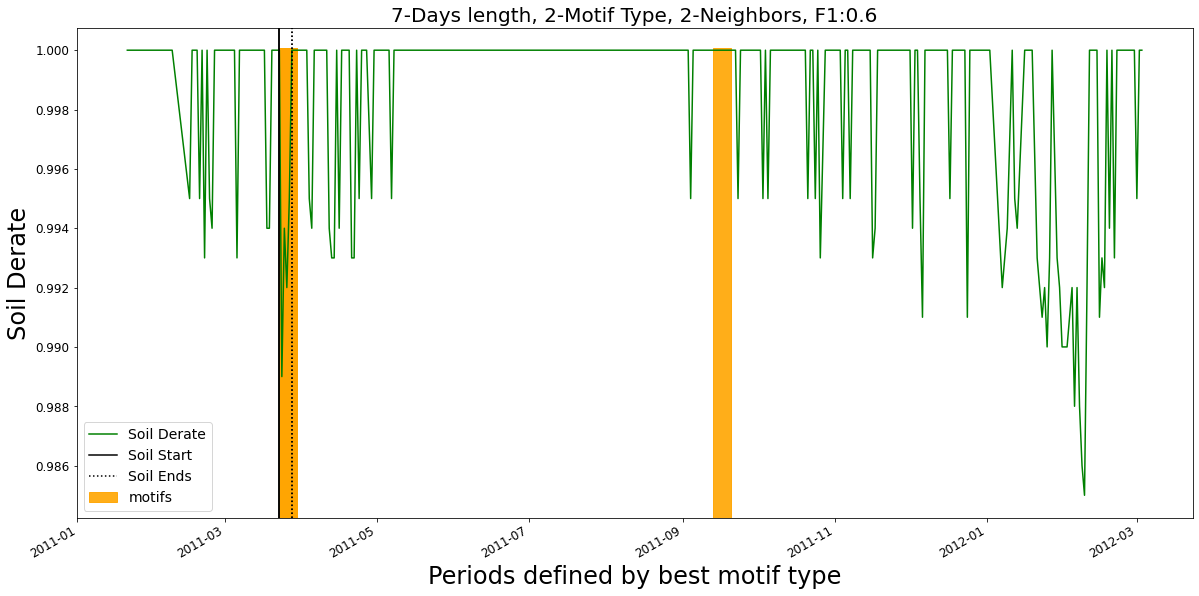

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       325
         1.0       0.43      1.00      0.60         6

    accuracy                           0.98       331
   macro avg       0.71      0.99      0.79       331
weighted avg       0.99      0.98      0.98       331



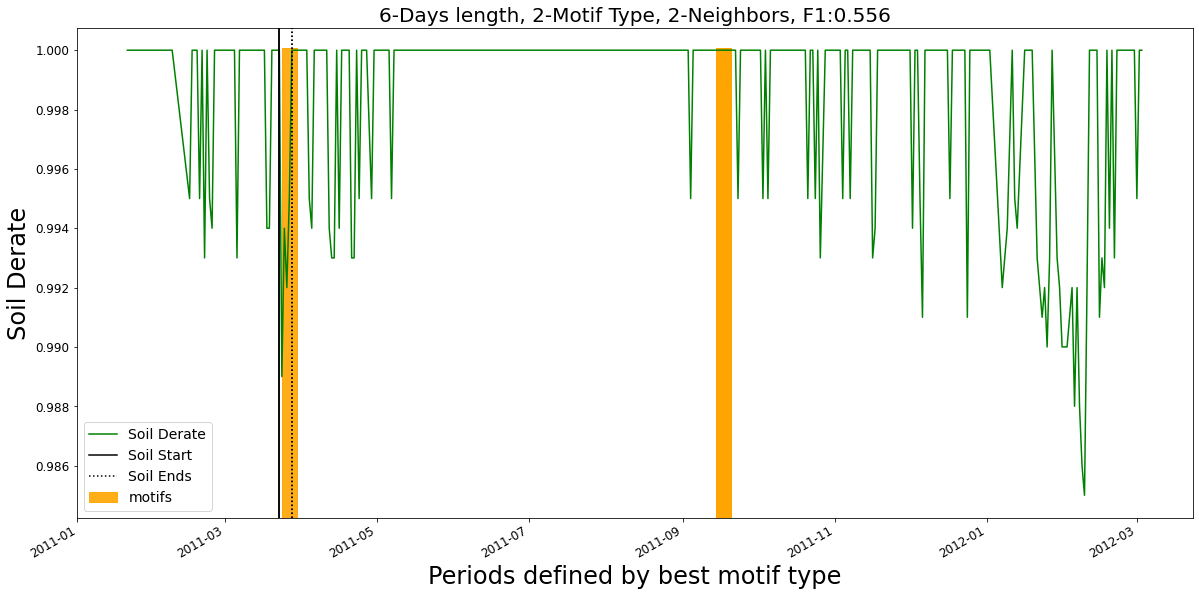

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       325
         1.0       0.42      0.83      0.56         6

    accuracy                           0.98       331
   macro avg       0.71      0.91      0.77       331
weighted avg       0.99      0.98      0.98       331

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [10]:
files=['golden.csv',
       'cocoa.csv']
count=1
for i,file in enumerate(files):
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(file)
    print(f'{count}/{len(files)}')
    count=count+1
    filename = file
    df=pd.read_csv(filename)
    df['timestamp']=pd.to_datetime(df['timestamp'])
    df=df.set_index('timestamp')
    #testing step
    if file == 'eugene.csv':
      df2 = pd.DataFrame(index = pd.date_range('2014-01-21','2014-02-4', freq='D'))
# df=pd.concat([df,df[:15].reset_index(drop=True).set_index(df2.index)])
      df=pd.concat([df,df2])
      df.soiling_derate=df.soiling_derate.fillna(1)
      df=df.interpolate(method='linear')
    if file=='golden.csv':
        df=df.loc[:'2013-06-24']

        df.soiling_derate[0]=1
        df.soiling_derate[1]=1

    df.soiling_derate[-1]=1
    ##testing step
    print('We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event')
    print(f'Shape of our Timeseries: {df.shape}')
    df_soil_output=soiling_dates(df,y=x,plot=False)
    df_soil_output=df_soil_output[:-1]
#     print(f'Here we observe the exact dates which a soiling interval starts and stops')
#     print(df_soil_output)
    events=len(df_soil_output)
    eval_df,_,_=evaluate_motifs(col,df,df_soil_output,alles_df=end_df[['min_nei', 'max_d', 'cutoff', 'max_m', 'max_motif', 'profile_wind','exclusion_zone']])
    eval_df=pd.concat([end_df[['min_nei', 'max_d', 'cutoff', 'max_m', 'max_motif', 'profile_wind','exclusion_zone']],eval_df],axis=1)
    eval_df=eval_df.loc[eval_df[['f1']].drop_duplicates(['f1']).index]
    eval_df=eval_df.sort_values(by='f1',ascending=False)
    eval_df=eval_df.reset_index(drop=True)
    print(eval_df.head())
    # eval_df.to_csv(f'/home/pgidarakos/Genetic/Eugene/direct_eval_{i}_deliv.csv',columns=eval_df.columns,index=False)

    motif_graph_multi_dim_eval(col=col,df=df,
                      df_soil_output=df_soil_output,
                      alles_df=eval_df,n=2,plot=True)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")